#Queuing Simulator Implementation, model validation and long time scale statistics

Author: Ufuk Usubutun

usubutun[at]nyu[dot]edu

Supplementary material for our article "Backbone Switches No Longer Need To Deliver Packets in Sequence" (U. Usubutun, F. Fund, S. S. Panwar)

This notebook contains

* Scripts to compare our G/G/1 model with simulation resulst.
* Our discrete event simulator capturing load-balanced switches that can be fed with real packet traces
* Scripts to run longer simulations and obtain long time scale measurements.



In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma

import pickle
from collections import deque


import seaborn as sns
sns.set()
sns.set_style("white")
%pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
# helper function
def sns_ccdfplot(data, x=None, hue=None, linestyle='-', log_scale=True, ax=None, **kwargs):
    """
    Plots the empirical complementary cumulative distribution function (CCDF)
    using seaborn styling, and optionally plots on a provided matplotlib Axes object.

    Parameters:
        data (pd.DataFrame or pd.Series): The input data.
            - If a DataFrame, use `x` to specify the column name for the values.
            - If a Series, a default column name 'values' is used (if x is None).
        x (str, optional): Column name to compute the CCDF for (if data is a DataFrame).
        hue (str, optional): Column name for categorical separation (only for DataFrames).
        linestyle (str, optional): Line style for the plot.
        log_scale (bool, optional): Whether to set the y-axis to a logarithmic scale.
        ax (matplotlib.axes.Axes, optional): An existing Axes to plot on. If None, one is created.
        **kwargs: Additional keyword arguments passed to sns.lineplot().

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.
    """
    # Handle input: if data is a Series, convert it to a DataFrame with a default column name.
    if isinstance(data, pd.Series):
        df = pd.DataFrame({x or 'values': data})
        x = df.columns[0]
    else:
        df = data.copy()

    # Sort the DataFrame by the x column.
    df = df.sort_values(by=x)


    if hue:
        df['ecdf'] = df.groupby(hue).cumcount() / df.groupby(hue)[x].transform('count')
    else:
        df['ecdf'] = np.arange(len(df)) / len(df)  # Ensures last value has CCDF > 0

    df['ccdf'] = 1 - df['ecdf']  # CCDF is properly computed

    # If no Axes object is provided, create one.
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Plot using seaborn's lineplot to maintain its styling.
    sns.lineplot(data=df, x=x, y='ccdf', hue=hue, linestyle=linestyle, ax=ax, **kwargs)

    # Customize the plot: labels, scale, grid, and title.
    ax.set_ylabel("CCDF")
    if log_scale:
        ax.set_yscale("log")
    ax.grid(True)
    ax.set_title(f"Empirical CCDF of {x}")

    return ax, df



## Reading data in

In [ ]:
!apt install tshark

In [ ]:
%cd /mydata
!ls -l -h


/mydata
total 22G
-rw-r--r-- 1 uu20010 nyunetworks-PG0 989M Mar 21 17:23 CAIDA-2019-1.zip
-rw-r--r-- 1 uu20010 nyunetworks-PG0 2.7G Mar 21 18:43 CAIDA-2019-2.zip
-rw-r--r-- 1 uu20010 nyunetworks-PG0 4.2G Mar 21 16:25 equinix-nyc.dirA.20190117-133400.UTC.anon.csv
-rw-r--r-- 1 uu20010 nyunetworks-PG0 4.1G Mar 21 16:25 equinix-nyc.dirA.20190117-133400.UTC.anon.old.csv
-rw-r--r-- 1 uu20010 nyunetworks-PG0 9.7G Mar 21 18:35 equinix-nyc.dirB.20190117-131700.UTC.anon.csv
drwx------ 2 uu20010 root             16K Mar 21 12:05 lost+found


In [ ]:
!tshark -r equinix-nyc.dirA.20190117-133400.UTC.anon.pcap -T fields -e frame.time_epoch -e ip.src -e ipv6.src -e ip.dst -e ipv6.dst -e udp.srcport -e udp.dstport -e tcp.srcport -e tcp.dstport -e tcp.seq -e tcp.seq_raw -e tcp.ack -e tcp.ack_raw -e tcp.len -e tcp.flags -e ip.id -e ip.len -E header=y -E separator=, -E occurrence=a > equinix-nyc.dirA.20190117-133400.UTC.anon.extended.csv
#!tshark -r oc48-mfn.dirB.20020814-160000.UTC.anon.pcap -T fields -e frame.time_epoch -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e tcp.seq -e tcp.seq_raw -e tcp.ack -e tcp.ack_raw -e tcp.len -e tcp.flags -e ip.id -e ip.len -E header=y -E separator=, -E occurrence=a > 20241114-190000.dira.anon.sample.csv

Running as user "root" and group "root". This could be dangerous.


In [ ]:
df_in = []

# 2019 - 10g
###trace 1
'''
df_in = pd.read_csv(f'equinix-nyc.dirA.20190117-133400.UTC.anon.extended.csv',dtype={"frame.time_epoch": str})
#df_in = pd.read_csv(f'equinix-nyc.dirA.20190117-133400.UTC.anon.csv',dtype={"frame.time_epoch": str})
df_in_ts = pd.read_csv(f'equinix-nyc.dirA.20190117-133400.UTC.anon.times', names=['frame.time_epoch'], dtype={"frame.time_epoch": str})
df_in["frame.time_epoch"] = df_in_ts["frame.time_epoch"]
df_in_ts = []
'''


## 100g sampler A
#####df_in = pd.read_csv(f'20241114-190000.dira.anon.sample.csv',dtype={"frame.time_epoch": str})
df_in = pd.read_csv(f'20241114-190000.dira.anon.sample.extended.csv',dtype={"frame.time_epoch": str})


# 2.4 gbps oc48 public trace
#df_in = pd.read_csv(f'oc48-mfn.dirB.20020814-160000.UTC.anon.csv',dtype={"frame.time_epoch": str},on_bad_lines='skip')

In [ ]:
df_in

,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len
0,1731610799.999999896,NaN,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,NaN,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,NaN,NaN,443.0,56181.0,1.0,3.632087e+09,1.0,7.566330e+08,1440.0,0x0010,NaN,NaN
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0
3,1731610800.000000135,NaN,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,NaN,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1.0,3.115945e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN
4,1731610800.000000262,NaN,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,NaN,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1417.0,3.115960e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0


In [ ]:

df_in['ip.src'] = df_in['ip.src'].fillna(df_in['ipv6.src'])
df_in['ip.dst'] = df_in['ip.dst'].fillna(df_in['ipv6.dst'])
df_in

,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len
0,1731610799.999999896,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,NaN,NaN,443.0,56181.0,1.0,3.632087e+09,1.0,7.566330e+08,1440.0,0x0010,NaN,NaN
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0
3,1731610800.000000135,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1.0,3.115945e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN
4,1731610800.000000262,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1417.0,3.115960e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0


In [ ]:
# Get first entry and count decimal digits
first_ts = df_in['frame.time_epoch'].iloc[0]
decimal_digits = len(first_ts.split('.')[1]) if '.' in first_ts else 0
# Report
print(f"Decimal digits after '.' in first entry: {decimal_digits}")
# pads zeros if not enough decimal points are available (to be tested)
df_in['frame.time_epoch_ns'] = (df_in['frame.time_epoch'] + ('0' * (9 - decimal_digits))).str.replace('.', '', regex=False).astype('int64')

Decimal digits after '.' in first entry: 9


In [ ]:
df_in["frame.time_epoch_ns"] = df_in["frame.time_epoch_ns"] - df_in["frame.time_epoch_ns"].min()
df_in

,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len,frame.time_epoch_ns
0,1731610799.999999896,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,NaN,NaN,443.0,56181.0,1.0,3.632087e+09,1.0,7.566330e+08,1440.0,0x0010,NaN,NaN,0
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0,15
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0,121
3,1731610800.000000135,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1.0,3.115945e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN,239
4,1731610800.000000262,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1417.0,3.115960e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0,4999997244
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0,4999998296
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0,4999998780
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0,4999999646


#G/G/1 Model definition

In [ ]:
import numpy as np

def gg1_avg_delay(c_arr_2, c_serv_2, rho, mean_serv_rate):
    c_arr_2 = np.asarray(c_arr_2)
    rho = np.asarray(rho)

    g = np.where(
        c_arr_2 < 1,
        np.exp(-2 * (1 - rho) * (1 - c_arr_2)**2 / (3 * rho * (c_arr_2 + c_serv_2))),
        1.0
    )
    exp_wait = (1 / mean_serv_rate) * rho * (c_arr_2 + c_serv_2) * g / (2 * (1 - rho))
    return exp_wait

def gg1_fdFd(cD_2s, x, exp_delays, var_Ds):
    x = np.asarray(x)

    if cD_2s > 1.01:
        # case 1
        p = (1 + np.sqrt((cD_2s - 1) / (cD_2s + 1))) / 2
        gam1 = 2 * p / exp_delays
        gam2 = 2 * (1 - p) / exp_delays

        f_D = p * gam1 * np.exp(-gam1 * x) + (1 - p) * gam2 * np.exp(-gam2 * x)
        F_D = p * (1 - np.exp(-gam1 * x)) + (1 - p) * (1 - np.exp(-gam2 * x))

    elif cD_2s > 0.99:
        # case 2
        gam1 = 1 / exp_delays

        f_D = gam1 * np.exp(-gam1 * x)
        F_D = 1 - np.exp(-gam1 * x)

    elif cD_2s > 0.501:
        # case 3
        gam2 = 1 / ((exp_delays + np.sqrt(2 * var_Ds - exp_delays**2)) / 2)
        gam1 = 1 / (exp_delays - 1 / gam2)

        f_D = (gam1 * gam2 / (gam1 - gam2)) * (np.exp(-gam2 * x) - np.exp(-gam1 * x))
        F_D = 1 - ((gam1 * np.exp(-gam2 * x) - gam2 * np.exp(-gam1 * x)) / (gam1 - gam2))

    else:
        # case 4
        gam1 = 2 / exp_delays

        f_D = gam1**2 * x * np.exp(-gam1 * x)
        F_D = 1 - np.exp(-gam1 * x) * (1 + gam1 * x)

    return f_D, F_D


def compute_gg1_delay_distribution(p=0.4, capacity=400.5e9, rho=0.99, k_wei=0.8, x=None, return_stats=False):
    if x is None:
        x = np.logspace(-9, 1, 500)

    avg_pkt_size = (p * 64 + (1 - p) * 1518) * 8
    T = avg_pkt_size / capacity
    Cp = 1 / T

    short_service_time = 64 * 8 / capacity
    long_service_time = 1518 * 8 / capacity

    arr_rate = rho * Cp
    mean_interarr_time = 1 / arr_rate
    lam_wei = mean_interarr_time / gamma(1 + 1 / k_wei)

    c_arr_2 = gamma(1 + 2 / k_wei) / gamma(1 + 1 / k_wei)**2 - 1

    ds_3 = (p * short_service_time**3 + (1 - p) * long_service_time**3) / \
           (p * short_service_time + (1 - p) * long_service_time)**3
    c_serv_2 = (p * short_service_time**2 + (1 - p) * long_service_time**2) / \
               (p * short_service_time + (1 - p) * long_service_time)**2 - 1

    exp_wait = gg1_avg_delay(c_arr_2, c_serv_2, rho, Cp)
    exp_delay = exp_wait / rho

    cD_2 = 2 * rho - 1 + 4 * (1 - rho) * ds_3 / (3 * (c_serv_2 + 1)**2)
    var_D = exp_delay**2 * cD_2
    exp_D_2 = var_D + exp_delay**2

    f_D, F_D = gg1_fdFd(cD_2, x, exp_delay, var_D)

    if return_stats:
        return f_D, F_D, x, c_arr_2
    return f_D, F_D, x

#Packet Sims

Here you will find:
* the script of the queueing simulators (for FIFO and N queues)
* scripts to compare short time scale outputs with G/G/1 model predictions
* long time scale plotting

In [ ]:
df_in

,frame.time_epoch,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len,frame.time_epoch_ns
0,1731610799.999999896,NaN,NaN,443.0,56181.0,1.0,3.632087e+09,1.0,7.566330e+08,1440.0,0x0010,NaN,NaN,0
1,1731610799.999999911,200.94.51.188,78.204.37.10,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0,15
2,1731610800.000000017,68.72.224.71,93.179.112.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0,121
3,1731610800.000000135,NaN,NaN,443.0,40522.0,1.0,3.115945e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN,239
4,1731610800.000000262,NaN,NaN,443.0,40522.0,1417.0,3.115960e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,NaN,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,82.5.43.205,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0,4999997244
15832630,1731610804.999998192,232.96.227.181,126.33.88.182,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0,4999998296
15832631,1731610804.999998676,186.187.218.40,131.75.23.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0,4999998780
15832632,1731610804.999999542,74.139.200.240,90.38.213.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0,4999999646


In [ ]:
df_in = df_in.dropna(subset=["ip.len"])
#df_in = df_in[~df_in["ip.len"].astype(str).str.startswith("0x")]
df_in["ip.len"] = pd.to_numeric(df_in["ip.len"], errors='coerce')
df_in

/tmp/ipython-input-954877708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in["ip.len"] = pd.to_numeric(df_in["ip.len"], errors='coerce')


,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len,frame.time_epoch_ns
0,1731610799.999999896,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d5c2:3139:6e19:d1c7:f030:3f00:bdf6:dc12,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,d1c1:3856:41d9:efcc:9073:9f85:c5c4:bd40,NaN,NaN,443.0,56181.0,1.0,3.632087e+09,1.0,7.566330e+08,1440.0,0x0010,NaN,1460.0,0
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0,15
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0,121
3,1731610800.000000135,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1.0,3.115945e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,1436.0,239
4,1731610800.000000262,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d5c0:1501:b2c2:300b:f030:3f00:14a9:a3b5,d1c1:3856:4d00:4b32:5074:543b:703:16fb,d1c1:3856:4d00:4b32:5074:543b:703:16fb,NaN,NaN,443.0,40522.0,1417.0,3.115960e+08,1.0,3.860952e+09,1416.0,0x0010,NaN,1436.0,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0,4999997244
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0,4999998296
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0,4999998780
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0,4999999646


## G/G/1 vs Sims at short time scales

### Single queue

In [ ]:
swcap=60000 #60


Calculating for duration: 10.00 milliseconds:
Coeff of Var^2: 0.9845102106468805
Detrended fluctuation analysis: 0.5642241578848397
Hurst exponent (RS method): 0.5322177677322535
utilization: 72.1 %:
Solved k_wei: 1.0078449207234086
p with new mean logic: 0.5435064707920105
rho thru bit utilization: 0.7209791666666666
rho thru bit pkts/cp: 0.7209791666666665
fitted weibul c^2: 0.9845102106468786

Calculating for duration: 100.00 milliseconds:
Coeff of Var^2: 0.9875768861295467
Detrended fluctuation analysis: 0.5665201984825758
Hurst exponent (RS method): 0.5130592850716349
utilization: 74.3 %:
Solved k_wei: 1.006275722416403
p with new mean logic: 0.5439200997112182
rho thru bit utilization: 0.7428243333333333
rho thru bit pkts/cp: 0.7428243333333333
fitted weibul c^2: 0.9875768861295442
centered around 65.5389 s


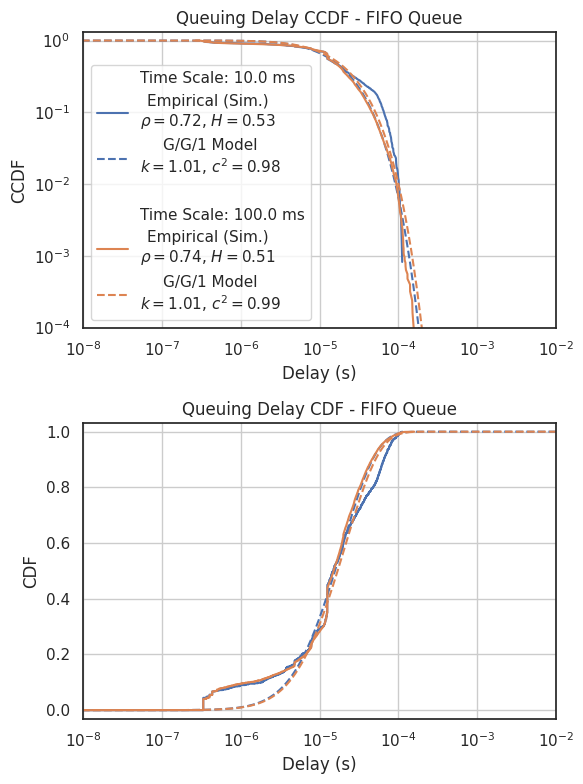

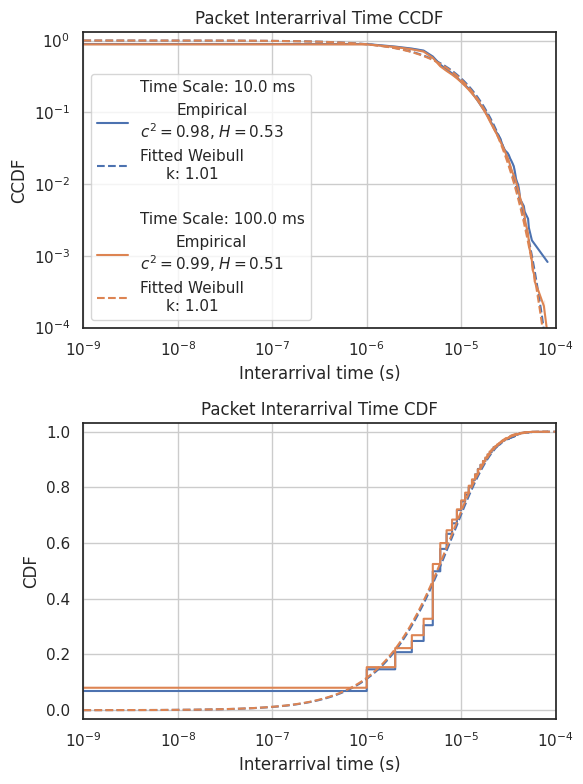

In [ ]:
# single queue - sim delay

import numpy as np
#from scipy.stats import expon
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import weibull_min
import nolds
from scipy.special import gamma
from scipy.optimize import root_scalar

import matplotlib.lines as mlines
import matplotlib.pyplot as plt


def func(k_wei, target):
        return gamma(1 + 2 / k_wei) / (gamma(1 + 1 / k_wei) ** 2) - 1 - target

fit_weibull = False
set_weibull_shape = not fit_weibull

start=15.2694e9
start=22e9 #.2694e9
start=65.5389e9 # used for 2.4gbps caida
#start=36.589e9 # used for 10gbps caida
#start=2.16087e9 # used for 100gbps caida



interarrival = []
'''
all_handles = [[[] for _ in range(2)] for _ in range(2)]  # 2x2 grid
all_labels = [[[] for _ in range(2)] for _ in range(2)]
'''

#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10)) #plt.subplots(figsize=(8, 5))
# Create two separate figures
fig_left, axs_left = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))   # [0][0], [1][0]
fig_right, axs_right = plt.subplots(nrows=2, ncols=1, figsize=(6, 8)) # [0][1], [1][1]

# Reconstruct a virtual 2x2 `ax` layout that still works with ax[i][j]
ax = [
    [axs_left[0], axs_right[0]],   # row 0: [0][0], [0][1]
    [axs_left[1], axs_right[1]]    # row 1: [1][0], [1][1]
]

i=0
for duration in [0.01*1e9,  0.1*1e9]: # 0.01*1e9,#, 0.5, 1, 3]: #3
  print(f"\nCalculating for duration: {(duration*1e-6):.2f} milliseconds:")


  interarrival = df_merged.loc[
        (df_merged["frame.time_epoch_ns_x"] > start - duration/2)
        & (df_merged["frame.time_epoch_ns_x"] < start + duration/2),
        "interarrival"]*1e-9

  x2 = np.logspace(-9, np.log10(interarrival.max()*5), 1000)

  empirical_c2 = np.var(interarrival)/(np.mean(interarrival)**2)
  print(f"Coeff of Var^2: {empirical_c2}")
  H_dfa = nolds.dfa(interarrival)
  print(f"Detrended fluctuation analysis: {H_dfa}")
  H_nolds_rs = nolds.hurst_rs(interarrival)
  print(f"Hurst exponent (RS method): {H_nolds_rs}")

  ####
  # calculate delays with the sim
  #######
  df_arrivals = df_merged.loc[ (df_merged["frame.time_epoch_ns_x"] > start - duration/2)
      & (df_merged["frame.time_epoch_ns_x"] < start + duration/2), ["frame.time_epoch_ns_x","ip.len"]].copy() #.to_frame()
  df_arrivals.reset_index(drop=True, inplace=True)
  df_arrivals["ip.len"] = df_arrivals["ip.len"]# 1500

  q_len=0 # in bytes

  arrivals = deque()
  arrivals.extend(df_arrivals.iloc[::-1].itertuples(index=False, name=None))

  departures = deque()

  q_state = deque()
  delay_meas = deque()

  link_rate=swcap*1e6 #bps
  byte_ns_rate = link_rate/8/1e9 # bytes per nanosecond
  q_len=0


  while len(arrivals) > 0:
  #for x in range(25):
    if q_len==0:
      arr_time, pkt_size = arrivals.pop()

      q_len = q_len + pkt_size

      q_state.append((arr_time, q_len))

      #prev_pkt_dep = departures[0][0] if len(departures) > 0 else arr_time

      serv_finish = arr_time + int(pkt_size/byte_ns_rate)
      departures.appendleft((serv_finish, pkt_size))

      delay_meas.append((arr_time, serv_finish - arr_time, pkt_size))
    else:
      if departures[-1][0] < arrivals[-1][0]:
        dep_time, pkt_size = departures.pop()

        q_len = q_len - pkt_size
        q_state.append((dep_time, q_len))
      else:
        arr_time, pkt_size = arrivals.pop()

        q_len = q_len + pkt_size

        q_state.append((arr_time, q_len))

        # this line is different and uses the departure of the latest queued pkt
        serv_finish = departures[0][0] + int(pkt_size/byte_ns_rate)
        departures.appendleft((serv_finish, pkt_size))

        delay_meas.append((arr_time, serv_finish - arr_time, pkt_size))


    #print(f"dep: {dep} \t arr: {arr} \t q_len: {q_len}")
    #print(f"q_len: {q_len}")

  df_delay_single = pd.DataFrame(list(delay_meas), columns=["timestamp_ns", "delay_ns", "pkt_size"])
  delays = df_delay_single["delay_ns"]*1e-9




  #utilization = delays.count() * 1500*8 / (duration*1e-9 * swcap*1e6 )
  utilization = df_delay_single["pkt_size"].sum()*8 / (duration*1e-9 * swcap*1e6 )

  print(f"utilization: {(utilization*100):.1f} %:")
  # Generate x values over a continuous range
  #x = np.linspace(delays.min(), delays.max()*1.5, 1000)
  x = np.logspace(-9, np.log10(delays.max()*100), 1000) #np.linspace(delays.min(), delays.max()*1.5, 1000)


  if fit_weibull:

    # Fit Weibull distribution to data
    shape_estimate, loc, scale_estimate = stats.weibull_min.fit(interarrival, floc=0)

    print(f"Estimated shape parameter k: {shape_estimate}")
    #print(f"Estimated scale parameter lambda: {scale_estimate}")

  elif set_weibull_shape:


    # Set your target value here
    target_value = empirical_c2  # for example 6.4#25#6#

    # Solve for k_wei
    result = root_scalar(func, args=(target_value,), bracket=[0.1, 20], method='brentq')

    if result.converged:
        print(f"Solved k_wei: {result.root}")
    else:
        print("Root finding did not converge.")

    shape_estimate = result.root


  # Parameters
  #p=(df_delay_single["pkt_size"] < 750).mean() # 0.7 # prob of 46 bytes vs 1500 bytes
  #print(f"p with old logic: {p}")
  p=(df_delay_single["pkt_size"].mean() - 1500)/(46-1500)
  print(f"p with new mean logic: {p}")

  avg_pkt_size = (p*46+(1-p)*1500) * 8.   #1514 * 8  # bits
  Cb = link_rate #4.5e9  # bottleneck capacity in bps
  T = avg_pkt_size / Cb  # average packet service duration at the bottleneck
  Cp = 1 / T  # capacity in pkts/sec

  short_service_time = 46*8/Cb
  long_service_time = 1500*8/Cb

  # System load
  rho = utilization #0.999
  print(f"rho thru bit utilization: {rho}")
  rho = delays.count() / (duration*1e-9 * Cp )
  print(f"rho thru bit pkts/cp: {rho}")

  arr_rate = delays.count() / (duration*1e-9 )
  #print(f"arr_rate thru pkt count/duration: {arr_rate}")

  #arr_rate = rho * Cp  # arrival rate in pkts/sec
  #print(f"arr_rate thru utilization: {arr_rate}")

  mean_interarr_time = 1 / arr_rate

  # Arrival process stats (Weibull)
  k_wei = shape_estimate #0.34 #3
  lam_wei = mean_interarr_time / gamma(1 + 1 / k_wei)

  m_wei = lam_wei * gamma(1 + 1 / k_wei)
  v_wei = lam_wei**2 * (gamma(1 + 2 / k_wei) - gamma(1 + 1 / k_wei)**2)
  c_arr_2 = gamma(1 + 2 / k_wei) / gamma(1 + 1 / k_wei)**2 - 1
  print(f"fitted weibul c^2: {c_arr_2}")

  # Service process stats (deterministic service)
  ds_3 = 1
  c_serv_2 = 0

  # Service process stats (bimodal)
  ds_3 = (p*short_service_time**3 + (1-p)*long_service_time**3)/(p*short_service_time+(1-p)*long_service_time)**3
  c_serv_2 = (p*short_service_time**2 + (1-p)*long_service_time**2)/(p*short_service_time+(1-p)*long_service_time)**2 - 1

  # Mean waiting time
  new_wait = gg1_avg_delay(c_arr_2, c_serv_2, rho, Cp)
  exp_wait = new_wait
  exp_delay = new_wait / rho

  # Squared coefficient of delay
  cD_2 = 2 * rho - 1 + 4 * (1 - rho) * ds_3 / (3 * (c_serv_2 + 1)**2)

  # Second moment and variance
  var_D = exp_delay**2 * cD_2
  exp_D_2 = var_D + exp_delay**2

  # Select the first value (in case of array input, but here scalar)
  select = 0
  cD_2s = np.atleast_1d(cD_2)[select]
  var_Ds = np.atleast_1d(var_D)[select]
  exp_D_2s = np.atleast_1d(exp_D_2)[select]
  exp_delays = np.atleast_1d(exp_delay)[select]
  rhos = np.atleast_1d(rho)[select]

  # Time vector
  #x = np.logspace(-8, 0, 100)

  # Compute delay distribution
  f_D, F_D = gg1_fdFd(cD_2s, x, exp_delays, var_Ds)

  # Optional: MM1 reference
  mu_serv_mm1 = Cb / pkt_size

  #exp_mean = delays.mean()  # Exponential distribution mean
  #lambda_ = 1 / exp_mean  # Rate parameter λ

  # Compute the CDF of the exponential distribution
  # cdf = expon.cdf(x, scale=exp_mean)  # scale = 1/λ

  color = sns.color_palette()[i % 10]  # Cycle through Seaborn colors

  # Plot the fitted exponential CDF
  # ccdf
  if i != 0:
      ax[0][0].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
      ax[1][0].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
  ax[0][0].plot([np.nan], [np.nan], label=f'Time Scale: {duration*1e-6:.1f} ms', color='none', linestyle='None')
  sns_ccdfplot(delays, label="Empirical (Sim.)\n" + rf"$\rho={rho:.2f}$, $H={H_nolds_rs:.2f}$" , color=color, ax=ax[0][0], log_scale=True)
  ax[0][0].plot(x, 1-F_D, label="G/G/1 Model\n"+ f"$k={shape_estimate:.2f}$, $c^2={empirical_c2:.2f}$", color=color, linestyle="--")
  # cdf
  sns.ecdfplot(delays, label=f"empirical - Duration: {duration*1e-6:.2f} ms" , color=color, ax=ax[1][0])
  ax[1][0].plot(x, F_D, label=f"model- (rho={rho:.2f})", color=color, linestyle="--")
  if fit_weibull:
    #ccdf
    sns_ccdfplot(interarrival, label=f"Empirical - Scale: {duration*1e-6:.2e} ms" , color=color, ax=ax[0][1], log_scale=True)
    ax[0][1].plot(x2, 1-weibull_min.cdf(x2, shape_estimate, scale=scale_estimate), color=color, linestyle=":", label=f"shape est: {shape_estimate:.2f}, resulting scale: {scale_estimate}")
    #cdf
    sns.ecdfplot(interarrival, label=f"empirical - Duration: {duration*1e-6:.2e} ms" , color=color, ax=ax[1][1])
    ax[1][1].plot(x2, weibull_min.cdf(x2, shape_estimate, scale=scale_estimate), color=color, linestyle=":", label=f"shape est: {shape_estimate:.2f}, resulting scale: {scale_estimate}")
  elif set_weibull_shape:
    #ccdf
    #dummy, =
    if i != 0:
      ax[0][1].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
      ax[1][1].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
    ax[0][1].plot([np.nan], [np.nan], label=f'Time Scale: {duration*1e-6:.1f} ms', color='none', linestyle='None')
    sns_ccdfplot(interarrival, label="Empirical\n"+f"$c^2={empirical_c2:.2f}$, $H={H_nolds_rs:.2f}$" , color=color, ax=ax[0][1], log_scale=False)
    #empirical = ax[0][1].lines[-1]  # Last line added
    #theory, =
    ax[0][1].plot(x2, 1-weibull_min.cdf(x2, shape_estimate, scale=lam_wei), color=color, linestyle="--", label="Fitted Weibull\n" +f"k: {shape_estimate:.2f}")# , calculated scale: {lam_wei:.2e}")
    #all_handles[0][1].extend([dummy, empirical, theory])
    #all_labels[0][1].extend([dummy.get_label(), empirical.get_label(), theory.get_label()])
    #cdf
    sns.ecdfplot(interarrival, label=f"empirical - Duration: {duration*1e-6:.2f} ms" , color=color, ax=ax[1][1])
    ax[1][1].plot(x2, weibull_min.cdf(x2, shape_estimate, scale=lam_wei), color=color, linestyle="--", label=f"used shape: {shape_estimate:.2f}, calculated scale: {lam_wei:.2e}")
  #ax[0].set_ylim((-0.1,1.03))
  #
  #sns.ecdfplot( df_merged.loc[ (df_merged['frame.time_epoch_x'] > start) & (df_merged['frame.time_epoch_x'] < start+duration), 'delay' ]*1e3, label=duration )
  i=i+1

#ax[0].set_ylim((-0.1,1.03))
ax[0][0].set_xlabel('Delay (s)')
ax[0][0].set_xscale("log")
ax[0][0].set_ylabel('CCDF')
ax[0][0].set_ylim((1e-4,1.3))
ax[0][0].set_xlim((1e-8,1e-2)) #((1e-9,1e-4)) #((1e-9,1e-3)) #((1e-8,1e-2))
ax[0][0].set_title(f'Queuing Delay CCDF - FIFO Queue')
lll=ax[0][0].legend(loc='lower left')
# Center-align each label inside the legend box
for text in lll.get_texts():
    text.set_horizontalalignment('center')
ax[0][0].grid(True)
#ax[1].set_ylim((-0.1,1.03))
ax[0][1].set_xlabel('Interarrival time (s)')
ax[0][1].set_xscale("log")
ax[0][1].set_yscale("log")
ax[0][1].set_ylabel('CCDF')
ax[0][1].set_ylim((1e-4,1.3))
ax[0][1].set_xlim((1e-9,1e-4))
ax[0][1].set_title(f'Packet Interarrival Time CCDF')
lll=ax[0][1].legend(loc='lower left')
# Center-align each label inside the legend box
for text in lll.get_texts():
    text.set_horizontalalignment('center')
ax[0][1].grid(True)


ax[1][0].set_xlabel('Delay (s)')
ax[1][0].set_xscale("log")
ax[1][0].set_ylabel('CDF')
ax[1][0].set_title(f'Queuing Delay CDF - FIFO Queue')
ax[1][0].set_ylim((-0.03,1.03))
ax[1][0].set_xlim((1e-8,1e-2)) #((1e-9,1e-4)) #((1e-9,1e-3)) #((1e-8,1e-2))
#ax[1][0].legend()
ax[1][0].grid(True)

ax[1][1].set_xlabel('Interarrival time (s)')
ax[1][1].set_xscale("log")
ax[1][1].set_ylabel('CDF')
ax[1][1].set_title(f'Packet Interarrival Time CDF')
ax[1][1].set_ylim((-0.03,1.03))
ax[1][1].grid(True)
ax[1][1].set_xlim((1e-9,1e-4))
#plt.legend()
#plt.legend(fontsize=8)  # Adjust the font size (e.g., 10)
#plt.grid(True)
fig_left.tight_layout()
fig_right.tight_layout()
fig_left.savefig(f"delay_fit_c_t{(start*1e-6):.0f}ms_swcap{swcap}.pdf")
fig_right.savefig(f"interarrival_fit_c_t{(start*1e-6):.0f}ms.pdf")
print(f"centered around {(start*1e-9):.4f} s")
plt.show()


Text(0.5, 1.0, 'Delay over Time for single queue system')

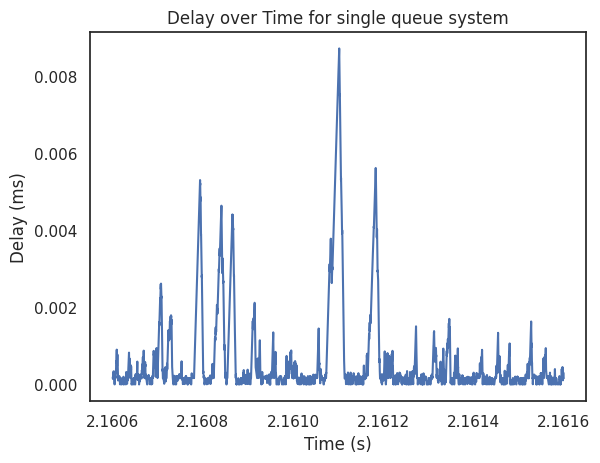

In [ ]:
plt.plot(df_delay_single["timestamp_ns"]/1e9, df_delay_single["delay_ns"]/1e6)
plt.xlabel('Time (s)')
plt.ylabel('Delay (ms)')
plt.title('Delay over Time for single queue system')

### N queues

In [ ]:
swcap=60000 #30000


Calculating for duration: 0.10 milliseconds:
Coeff of Var^2: 1.2934134655192724
Detrended fluctuation analysis: 0.6457382366737682
Hurst exponent (RS method): 0.5590453351158956
utilization: 26.7 %:
Solved k_wei: 0.8814959577680901
p with new mean logic: 0.4055458296861323
rho thru bit utilization: 0.267032
rho thru bit pkts/cp: 0.267032
fitted weibul c^2: 1.2934134655192722
c_serv^2: 0.615011658839397
mm1 rho: 0.26703200000000005
1.3247856039355805us

Calculating for duration: 1.00 milliseconds:
Coeff of Var^2: 1.3559887852181411
Detrended fluctuation analysis: 0.6412128775413646
Hurst exponent (RS method): 0.6115667603702623
utilization: 36.3 %:
Solved k_wei: 0.8618050375498275
p with new mean logic: 0.3048106252330082
rho thru bit utilization: 0.3634001333333333
rho thru bit pkts/cp: 0.3634001333333333
fitted weibul c^2: 1.3559887852181438
c_serv^2: 0.40111789123553665
mm1 rho: 0.3634001333333333
1.7707497283567653us
centered around 2.17193 s - 2172


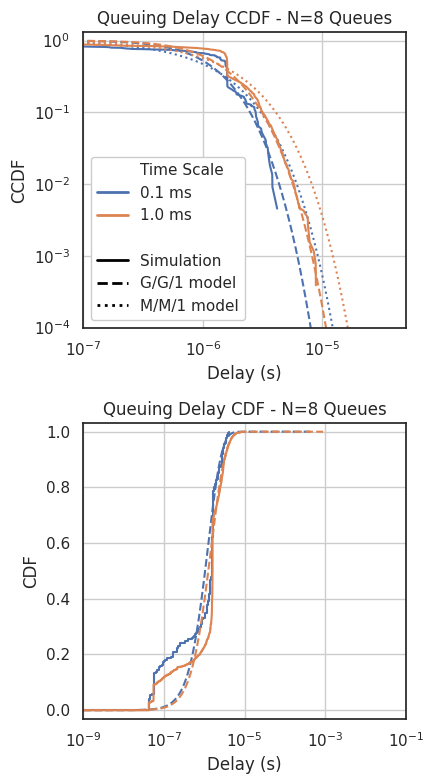

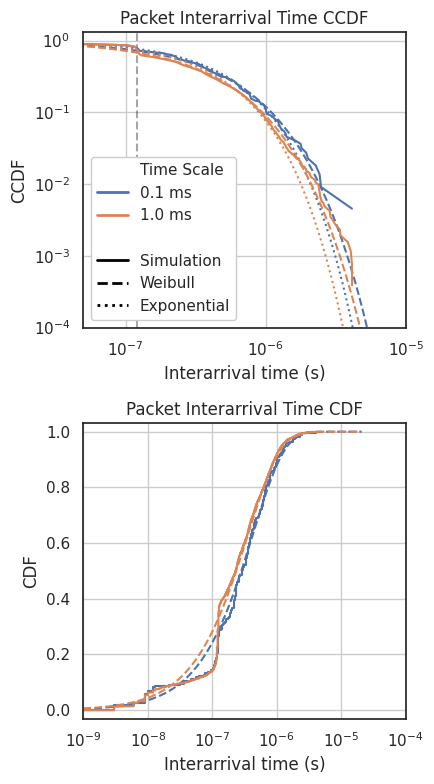

In [ ]:
# N queues - sim delay

import numpy as np
#from scipy.stats import expon
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import weibull_min
import nolds
from scipy.special import gamma
from scipy.optimize import root_scalar

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

#sns.set_style("white")

printout=' '

def func(k_wei, target):
        return gamma(1 + 2 / k_wei) / (gamma(1 + 1 / k_wei) ** 2) - 1 - target

plot_mm1 = True

fit_weibull = False
set_weibull_shape = not fit_weibull


#start=15.781e9
#start=65.5389e9 # used for 2.4gbps caida
#start=36.589e9 # used for 10gbps caida
#start=2.16087e9 # used for 100gbps caida

#start=3.819e9
#start=2.17193e9 #  100g
#start=2.160464e9 #  100g

# number of queues
N = 8

colors_used = []
durations_used = []


interarrival = []


fig_left, axs_left = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 8))   # [0][0], [1][0]
fig_right, axs_right = plt.subplots(nrows=2, ncols=1, figsize=(4.5, 8)) # [0][1], [1][1]

# Reconstruct a virtual 2x2 `ax` layout that still works with ax[i][j]
ax = [
    [axs_left[0], axs_right[0]],   # row 0: [0][0], [0][1]
    [axs_left[1], axs_right[1]]    # row 1: [1][0], [1][1]
]

i=0
for duration in [0.0001*1e9,  0.001*1e9]: # 0.01*1e9,#, 0.5, 1, 3]: #3
  print(f"\nCalculating for duration: {(duration*1e-6):.2f} milliseconds:")


  interarrival = df_merged.loc[
        (df_merged["frame.time_epoch_ns_x"] > start - duration/2)
        & (df_merged["frame.time_epoch_ns_x"] < start + duration/2),
        "interarrival"]*1e-9

  x2 = np.logspace(-9, np.log10(interarrival.max()*5), 1000)

  empirical_c2 = np.var(interarrival)/(np.mean(interarrival)**2)
  print(f"Coeff of Var^2: {empirical_c2}")
  H_dfa = nolds.dfa(interarrival)
  print(f"Detrended fluctuation analysis: {H_dfa}")
  H_nolds_rs = nolds.hurst_rs(interarrival)
  print(f"Hurst exponent (RS method): {H_nolds_rs}")

  ####
  # calculate delays with the sim
  #######
  df_arrivals = df_merged.loc[ (df_merged["frame.time_epoch_ns_x"] > start - duration/2)
      & (df_merged["frame.time_epoch_ns_x"] < start + duration/2), ["frame.time_epoch_ns_x","ip.len"]].copy() #.to_frame()
  df_arrivals.reset_index(drop=True, inplace=True)
  df_arrivals["ip.len"] = df_arrivals["ip.len"]# 1500

  arrivals = deque()
  arrivals.extend(df_arrivals.iloc[::-1].itertuples(index=False, name=None))
  #arrivals.extend(df_in_first_100k.iloc[::-1].itertuples(index=False, name=None))



  q_len=[0] * N

  # Create a list of n empty deques
  departures = [deque() for _ in range(N)]


  q_state = [deque() for _ in range(N)]
  delay_meas = [deque() for _ in range(N)]

  random_q_select = deque()
  random_q_select.extend( list(np.random.randint(0, N, size=len(arrivals))))

  link_rate=swcap*1e6 #bps
  byte_ns_rate = link_rate/8/1e9/N # bytes per nanosecond
  q_len=[0] * N

  while len(arrivals) > 0:
  #for x in range(100):
    if sum(q_len)==0:
      arr_time, pkt_size = arrivals.pop()
      #arr_time, pkt_size, pkt_id = arrivals.pop()
      target_q = random_q_select.pop()

      q_len[target_q] = q_len[target_q] + pkt_size

      q_state[target_q].append((arr_time, q_len[target_q]))

      serv_finish = arr_time + int(pkt_size/byte_ns_rate)
      departures[target_q].appendleft((serv_finish, pkt_size))

      delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_size))
      #delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_size, pkt_id))
    else:
      # Initialize variables to store the smallest value and its index
      smallest_value = float('inf')  # Start with a very large value
      smallest_index = -1  # To store the index of the deque with the smallest value

      # Iterate through the list of deques
      for j, dq in enumerate(departures):
          if dq:  # Check if the deque is not empty
              last_value = dq[-1][0]  # Get the value at index [-1]
              if last_value < smallest_value:  # If it's smaller than the current smallest value
                  smallest_value = last_value
                  smallest_index = j  # Update the index of the deque

      this_q_index = smallest_index
      this_q_departure_time = smallest_value

      if this_q_departure_time < arrivals[-1][0]:
        dep_time, pkt_size = departures[this_q_index].pop()

        q_len[this_q_index] = q_len[this_q_index] - pkt_size
        q_state[this_q_index].append((dep_time, q_len[this_q_index]))
      else:
        arr_time, pkt_size = arrivals.pop()
        #arr_time, pkt_size, pkt_id = arrivals.pop()
        target_q = int(random_q_select.pop())

        q_len[target_q] = q_len[target_q] + pkt_size

        q_state[target_q].append((arr_time, q_len[target_q]))

        prev_pkt_dep = departures[target_q][0][0] if len(departures[target_q]) > 0 else arr_time
        serv_finish = prev_pkt_dep + int(pkt_size/byte_ns_rate)
        departures[target_q].appendleft((serv_finish, pkt_size))

        delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_size))
        #delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_size, pkt_id))


    #print(f"dep: {dep} \t arr: {arr} \t q_len: {q_len}")
    #print(f"q_len: {q_len}")

  # Initialize an empty list to collect the rows for the DataFrame
  rows = []

  # Iterate through the list of deques
  for j, dq in enumerate(delay_meas):
      # Convert deque to a list of rows
      df_delay = pd.DataFrame(list(dq), columns=["timestamp_ns", "delay_ns", "pkt_size"])
      #df_delay = pd.DataFrame(list(dq), columns=["timestamp_ns", "delay_ns", "pkt_size", "pkt_id"])
      # Add the queue number column
      df_delay["queue_num"] = j
      # Append the dataframe rows to the list
      rows.append(df_delay)

  # Concatenate all the DataFrames into one
  df_delay_Nq = pd.concat(rows, ignore_index=True)

  # Print the final dataframe
  delays = df_delay_Nq["delay_ns"]*1e-9



  #utilization = delays.count() * 1500*8 / (duration*1e-9 * swcap*1e6 )
  utilization = df_delay_Nq["pkt_size"].sum()*8 / (duration*1e-9 * swcap*1e6 )

  print(f"utilization: {(utilization*100):.1f} %:")
  # Generate x values over a continuous range
  #x = np.linspace(delays.min(), delays.max()*1.5, 1000)
  x = np.logspace(-9, np.log10(delays.max()*100), 1000) #np.linspace(delays.min(), delays.max()*1.5, 1000)


  if fit_weibull:

    # Fit Weibull distribution to data
    shape_estimate, loc, scale_estimate = stats.weibull_min.fit(interarrival, floc=0)

    print(f"Estimated shape parameter k: {shape_estimate}")
    #print(f"Estimated scale parameter lambda: {scale_estimate}")

  elif set_weibull_shape:


    # Set your target value here
    target_value = empirical_c2  # for example 6.4#25#6#

    # Solve for k_wei
    result = root_scalar(func, args=(target_value,), bracket=[0.1, 20], method='brentq')

    if result.converged:
        print(f"Solved k_wei: {result.root}")
    else:
        print("Root finding did not converge.")

    shape_estimate = result.root


  # Parameters
  p=(df_delay_Nq["pkt_size"].mean() - 1500)/(46-1500)
  print(f"p with new mean logic: {p}")

  avg_pkt_size = (p*46+(1-p)*1500) * 8.   #1514 * 8  # bits
  Cb = link_rate/N  # bottleneck capacity in bps
  T = avg_pkt_size / Cb  # average packet service duration at the bottleneck
  Cp = 1 / T  # capacity in pkts/sec

  short_service_time = 46*8/Cb
  long_service_time = 1500*8/Cb

  # System load
  rho = utilization #0.999
  print(f"rho thru bit utilization: {rho}")
  rho = delays.count() / (duration*1e-9 * Cp *N)
  print(f"rho thru bit pkts/cp: {rho}")

  arr_rate = delays.count() / (duration*1e-9 )
  #print(f"arr_rate thru pkt count/duration: {arr_rate}")

  #arr_rate = rho * Cp  # arrival rate in pkts/sec
  #print(f"arr_rate thru utilization: {arr_rate}")

  mean_interarr_time = 1 / arr_rate

  # Arrival process stats (Weibull)
  k_wei = shape_estimate #0.34 #3
  lam_wei = mean_interarr_time / gamma(1 + 1 / k_wei)

  m_wei = lam_wei * gamma(1 + 1 / k_wei)
  v_wei = lam_wei**2 * (gamma(1 + 2 / k_wei) - gamma(1 + 1 / k_wei)**2)
  c_arr_2 = gamma(1 + 2 / k_wei) / gamma(1 + 1 / k_wei)**2 - 1
  print(f"fitted weibul c^2: {c_arr_2}")

  # Service process stats (deterministic service)
  #ds_3 = 1
  #c_serv_2 = 0

  # Service process stats (bimodal)
  ds_3 = (p*short_service_time**3 + (1-p)*long_service_time**3)/(p*short_service_time+(1-p)*long_service_time)**3
  c_serv_2 = (p*short_service_time**2 + (1-p)*long_service_time**2)/(p*short_service_time+(1-p)*long_service_time)**2 - 1
  print(f"c_serv^2: {c_serv_2}")


  # Mean waiting time
  new_wait = gg1_avg_delay(c_arr_2, c_serv_2, rho, Cp)
  exp_wait = new_wait
  exp_delay = new_wait / rho

  # Squared coefficient of delay
  cD_2 = 2 * rho - 1 + 4 * (1 - rho) * ds_3 / (3 * (c_serv_2 + 1)**2)

  # Second moment and variance
  var_D = exp_delay**2 * cD_2
  exp_D_2 = var_D + exp_delay**2

  # Select the first value (in case of array input, but here scalar)
  select = 0
  cD_2s = np.atleast_1d(cD_2)[select]
  var_Ds = np.atleast_1d(var_D)[select]
  exp_D_2s = np.atleast_1d(exp_D_2)[select]
  exp_delays = np.atleast_1d(exp_delay)[select]
  rhos = np.atleast_1d(rho)[select]


  # Compute delay distribution
  f_D_perN, F_D_preN = gg1_fdFd(cD_2s, x, exp_delays, var_Ds)

  #exp_mean = delays.mean()  # Exponential distribution mean
  #lambda_ = 1 / exp_mean  # Rate parameter λ

  if plot_mm1:
    pkt_size_bits=avg_pkt_size*8 #8*681.38
    serv_rate_mm1=Cp #1.05e9/pkt_size_bits/8
    arr_rate_mm1=arr_rate/N #0.6280603052675459e9/pkt_size_bits/8
    mm1_delay=  np.exp(-x*(serv_rate_mm1-arr_rate_mm1))
    mm1_interarr = np.exp(-x2*arr_rate)

    #rho=(arr_rate_mm1/serv_rate_mm1)
    #print(rho)
    print(f"mm1 rho: {arr_rate_mm1/serv_rate_mm1}")
    print(f"{1e6/(serv_rate_mm1-arr_rate_mm1)}us")


  # Compute the CDF of the exponential distribution
  # cdf = expon.cdf(x, scale=exp_mean)  # scale = 1/λ
  color = sns.color_palette()[i % 10]  # Cycle through Seaborn colors

  colors_used.append(color)
  durations_used.append(duration)

  # Plot the fitted exponential CDF
  # ccdf
  #if i != 0:
      #ax[0][0].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
      #ax[1][0].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
  #ax[0][0].plot([np.nan], [np.nan], label=f'Time Scale: {duration*1e-6:.1f} ms', color='none', linestyle='None')
  #ax[0][0].plot([np.nan], [np.nan], label=f'Time Scale: {duration*1e-6:.1f} ms\n'+rf'$\rho={rho:.2f}$', color='none', linestyle='None')
  #sns_ccdfplot(delays, label="Empirical (Sim.)\n" + rf"$\rho={rho:.2f}$, $H={H_nolds_rs:.2f}$" , color=color, ax=ax[0][0], log_scale=True)
  sns_ccdfplot(delays , color=color, ax=ax[0][0], log_scale=True) # , label="Simulation"
  #ax[0][0].plot(x, 1-F_D_preN, label="G/G/1 Model\n"+ f"$k={shape_estimate:.2f}$, $c^2={empirical_c2:.2f}$", color=color, linestyle="--")
  ax[0][0].plot(x, 1-F_D_preN, color=color, linestyle="--") # , label="G/G/1 Model"
  ax[0][0].plot(x, mm1_delay, color=color, linestyle=":") #, label="M/M/1 Model"
  # cdf
  sns.ecdfplot(delays, label=f"empirical - Duration: {duration*1e-6:.2f} ms" , color=color, ax=ax[1][0])
  ax[1][0].plot(x, F_D_preN, label=f"model- (rho={rho:.2f})", color=color, linestyle="--")
  if fit_weibull:
    #ccdf
    sns_ccdfplot(interarrival, label=f"Empirical - Scale: {duration*1e-6:.2e} ms" , color=color, ax=ax[0][1], log_scale=True)
    ax[0][1].plot(x2, 1-weibull_min.cdf(x2, shape_estimate, scale=scale_estimate), color=color, linestyle=":", label=f"shape est: {shape_estimate:.2f}, resulting scale: {scale_estimate}")
    #cdf
    sns.ecdfplot(interarrival, label=f"empirical - Duration: {duration*1e-6:.2e} ms" , color=color, ax=ax[1][1])
    ax[1][1].plot(x2, weibull_min.cdf(x2, shape_estimate, scale=scale_estimate), color=color, linestyle=":", label=f"shape est: {shape_estimate:.2f}, resulting scale: {scale_estimate}")
  elif set_weibull_shape:
    #ccdf
    #dummy, =
    #if i != 0:
    #  ax[0][1].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
    #  ax[1][1].plot([np.nan], [np.nan], label=f'   ', color='none', linestyle='None')
    ax[0][1].plot([np.nan], [np.nan], label=f'Time Scale: {duration*1e-6:.1f} ms', color='none', linestyle='None')
    #sns_ccdfplot(interarrival, label="Empirical\n"+f"$c^2={empirical_c2:.2f}$, $H={H_nolds_rs:.2f}$" , color=color, ax=ax[0][1], log_scale=False)
    sns_ccdfplot(interarrival , color=color, ax=ax[0][1], log_scale=False)

    #ax[0][1].plot(x2, 1-weibull_min.cdf(x2, shape_estimate, scale=lam_wei), color=color, linestyle="--", label="   Fitted Weibull\n   " +f"k: {shape_estimate:.2f}")# , calculated scale: {lam_wei:.2e}")
    ax[0][1].plot(x2, 1-weibull_min.cdf(x2, shape_estimate, scale=lam_wei), color=color, linestyle="--")# , calculated scale: {lam_wei:.2e}")
    ax[0][1].plot(x2, mm1_interarr, color=color, linestyle=":")# , calculated scale: {lam_wei:.2e}")

    #cdf
    sns.ecdfplot(interarrival, label=f"empirical - Duration: {duration*1e-6:.2f} ms" , color=color, ax=ax[1][1])
    ax[1][1].plot(x2, weibull_min.cdf(x2, shape_estimate, scale=lam_wei), color=color, linestyle="--", label=f"used shape: {shape_estimate:.2f}, calculated scale: {lam_wei:.2e}")
  #ax[0].set_ylim((-0.1,1.03))
  #
  #sns.ecdfplot( df_merged.loc[ (df_merged['frame.time_epoch_x'] > start) & (df_merged['frame.time_epoch_x'] < start+duration), 'delay' ]*1e3, label=duration )
  printout = printout + f"Time Scale: {duration*1e-6:.1f} H={H_nolds_rs:.2f} rho={rho:.2f} c^2={empirical_c2:.2f} k: {shape_estimate:.2f} p(of46B):{p} c_serv_2:{c_serv_2}\n "

  i=i+1

serialization_time=1500*8/(100*1e9)
#ax[0][1].plot([serialization_time,serialization_time], [1e-9,1e2], linestyle="--") #color='black'
ax[0][1].axvline(
    serialization_time,
    linestyle="--",
    color="black", alpha=0.35, zorder=1
)

from matplotlib.lines import Line2D

# ---- Time scale (color) legend entries ----
time_handles = [
    Line2D([0], [0], color=c, lw=2, label=f"{d*1e-6:.1f} ms")
    for d, c in zip(durations_used, colors_used)
]

# ---- Result type (linestyle) legend entries ----
result_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle="-",  label="Simulation"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="G/G/1 model"),
    Line2D([0], [0], color="black", lw=2, linestyle=":",  label="M/M/1 model"),
]

# ---- Section headers (dummy handles) ----
header_time   = Line2D([], [], color="none", label="Time Scale")
header_result = Line2D([], [], color="none", label="")

# ---- Final legend ----
handles = (
    [header_time] +
    time_handles +
    [header_result] +
    result_handles
)

ax[0][0].legend(handles=handles, frameon=True, framealpha=1)

# ---- Result type (linestyle) legend for interarrival plot ----
result_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle="-",  label="Simulation"),
    Line2D([0], [0], color="black", lw=2, linestyle="--", label="Weibull"),
    Line2D([0], [0], color="black", lw=2, linestyle=":",  label="Exponential"),
]

# ---- Headers ----
header_time   = Line2D([], [], color="none", label="Time Scale")
header_result = Line2D([], [], color="none", label="")

handles = (
    [header_time] +
    time_handles +
    [header_result] +
    result_handles
)

ax[0][1].legend(handles=handles, frameon=True, framealpha=1)


#ax[0].set_ylim((-0.1,1.03))
ax[0][0].set_xlabel('Delay (s)')
ax[0][0].set_xscale("log")
ax[0][0].set_ylabel('CCDF')
ax[0][0].set_ylim((1e-4,1.3))
#ax[0][0].set_xlim((1e-9,1e-1)) #((1e-9,1e-4)) #((1e-9,1e-3)) #((1e-8,1e-2))
ax[0][0].set_xlim((1e-7,5e-5))#((1e-7,3e-5)) # #((1e-8,1e-4)) #((1e-9,1e-4)) #((1e-9,1e-3)) #((1e-8,1e-2))
ax[0][0].set_title(f'Queuing Delay CCDF - N={N} Queues')
#lll= ax[0][0].legend(loc='lower left')
# Center-align each label inside the legend box
#for text in lll.get_texts():
#    text.set_horizontalalignment('center')
ax[0][0].grid(True)
#ax[1].set_ylim((-0.1,1.03))
ax[0][1].set_xlabel('Interarrival time (s)')
ax[0][1].set_xscale("log")
ax[0][1].set_yscale("log")
ax[0][1].set_ylabel('CCDF')
ax[0][1].set_ylim((1e-4,1.3))
#ax[0][1].set_xlim((1e-9,1e-4))
ax[0][1].set_xlim((5e-8,1e-5)) #((3e-8,1e-5)) #((1e-8,1e-5)) #((1e-9,1e-5))
ax[0][1].set_title(f'Packet Interarrival Time CCDF')
#lll=ax[0][1].legend(loc='lower left')
# Center-align each label inside the legend box
#for text in lll.get_texts():
#    text.set_horizontalalignment('center')
#ax[0][1].grid(True)


ax[1][0].set_xlabel('Delay (s)')
ax[1][0].set_xscale("log")
ax[1][0].set_ylabel('CDF')
ax[1][0].set_title(f'Queuing Delay CDF - N={N} Queues')
ax[1][0].set_ylim((-0.03,1.03))
ax[1][0].set_xlim((1e-9,1e-1)) #((1e-9,1e-4)) #((1e-9,1e-3)) #((1e-8,1e-2))
#ax[1][0].legend()
ax[1][0].grid(True)

ax[1][1].set_xlabel('Interarrival time (s)')
ax[1][1].set_xscale("log")
ax[1][1].set_ylabel('CDF')
ax[1][1].set_title(f'Packet Interarrival Time CDF')
ax[1][1].set_ylim((-0.03,1.03))
ax[1][1].grid(True)
ax[1][1].set_xlim((1e-9,1e-4))
#plt.legend()
#plt.legend(fontsize=8)  # Adjust the font size (e.g., 10)
#plt.grid(True)

fig_left.tight_layout()
fig_right.tight_layout()
fig_left.savefig(f"sim_delay_fit_c_t{(start*1e-6):.0f}ms_swcap{swcap}_N{N}_updated2026_1_7_take1.pdf")
fig_right.savefig(f"sim_interarrival_fit_c_t{(start*1e-6):.0f}_N{N}ms_updated2026_1_7_take1.pdf")
print(f"centered around {(start*1e-9):.5f} s - {(start*1e-6):.0f}")

with open(f"sim_params_c_t{(start*1e-6):.0f}ms_swcap{swcap}_N{N}_updated2026_1_7_take1.txt", "w") as f:
    f.write(printout)

plt.show()


Text(0.5, 1.0, 'Delay over Time for single queue system')

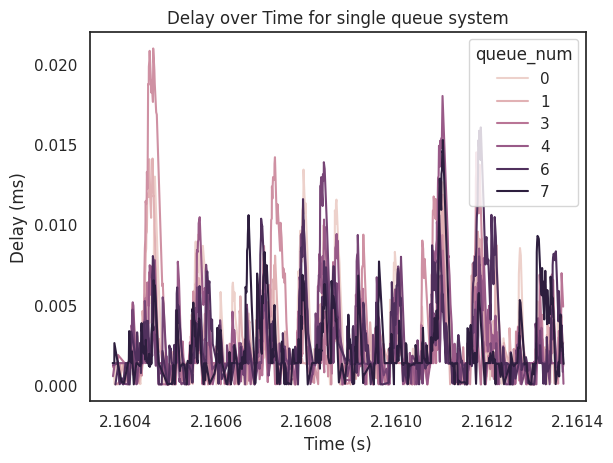

In [ ]:
sns.lineplot(x=df_delay_Nq["timestamp_ns"]/1e9, y=df_delay_Nq["delay_ns"]/1e6, hue=df_delay_Nq["queue_num"])
plt.xlabel('Time (s)')
plt.ylabel('Delay (ms)')
plt.title('Delay over Time for single queue system')

In [ ]:
from collections import deque

q_len=0 # in bytes

arrivals = deque()
arrivals.extend(df_in_first_100k.iloc[::-1].itertuples(index=False, name=None))

departures = deque()

q_state = deque()
delay_meas = deque()

link_rate=60e9#80e9 #bps
byte_ns_rate = link_rate/8/1e9 # bytes per nanosecond
q_len=0


while len(arrivals) > 0:
#for x in range(25):
  if q_len==0:
    #arr_time, pkt_size = arrivals.pop()
    arr_time, pkt_size, pkt_id = arrivals.pop()

    q_len = q_len + pkt_size

    q_state.append((arr_time, q_len))

    #prev_pkt_dep = departures[0][0] if len(departures) > 0 else arr_time

    serv_finish = arr_time + int(pkt_size/byte_ns_rate)
    departures.appendleft((serv_finish, pkt_size))

    delay_meas.append((arr_time, serv_finish - arr_time, pkt_size, pkt_id))
  else:
    if departures[-1][0] < arrivals[-1][0]:
      dep_time, pkt_size = departures.pop()

      q_len = q_len - pkt_size
      q_state.append((dep_time, q_len))
    else:
      #arr_time, pkt_size = arrivals.pop()
      arr_time, pkt_size, pkt_id = arrivals.pop()

      q_len = q_len + pkt_size

      q_state.append((arr_time, q_len))

      # this line is different and uses the departure of the latest queued pkt
      serv_finish = departures[0][0] + int(pkt_size/byte_ns_rate)
      departures.appendleft((serv_finish, pkt_size))

      delay_meas.append((arr_time, serv_finish - arr_time, pkt_size, pkt_id))
  #dep = departures[-1][0] if len(departures) > 0 else float('nan')
  #arr = arrivals[-1][0] if len(arrivals) > 0 else float('nan')
  #q_len = q_len if 'q_len' in locals() else float('nan')

  #print(f"dep: {dep} \t arr: {arr} \t q_len: {q_len}")
  #print(f"q_len: {q_len}")


KeyboardInterrupt: 

Text(0.5, 1.0, 'Delay over Time for single queue system')

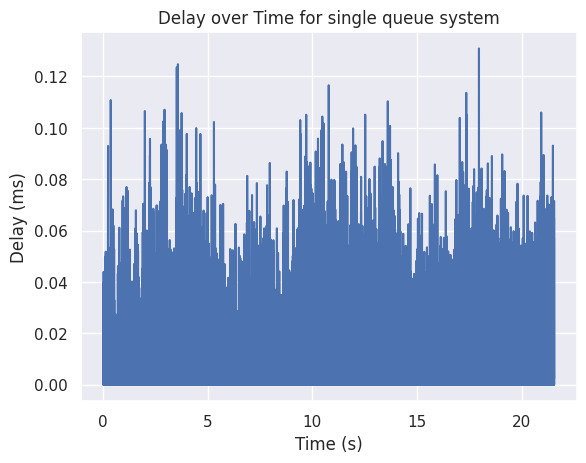

In [ ]:
plt.plot(df_delay_single["timestamp_ns"]/1e9, df_delay_single["delay_ns"]/1e6)
plt.xlabel('Time (s)')
plt.ylabel('Delay (ms)')
plt.title('Delay over Time for single queue system')

In [ ]:
df_qlen_single = pd.DataFrame(list(q_state), columns=["timestamp_ns", "queue_length_bytes"])
# Calculate the duration in nanoseconds by subtracting the current timestamp from the next one
df_qlen_single["duration_ns"] = df_qlen_single["timestamp_ns"].shift(-1) - df_qlen_single["timestamp_ns"]

# Drop the last row (since it has no next timestamp to subtract from)
df_qlen_single = df_qlen_single.dropna(subset=["duration_ns"])


df_sum_durations_single = df_qlen_single.groupby("queue_length_bytes")["duration_ns"].sum().reset_index()
df_sum_durations_single["prob_mass"] = df_sum_durations_single["duration_ns"]/df_sum_durations_single["duration_ns"].sum()
df_sum_durations_single["ecdf"] = df_sum_durations_single["prob_mass"].cumsum()
df_sum_durations_single

,queue_length_bytes,duration_ns,prob_mass,ecdf
0,0.0,233309292.0,7.631214e-01,0.763121
1,28.0,70.0,2.289600e-07,0.763122
2,29.0,89.0,2.911063e-07,0.763122
3,30.0,8.0,2.616686e-08,0.763122
4,31.0,102.0,3.336275e-07,0.763122
...,...,...,...,...
5848,13391.0,9.0,2.943772e-08,1.000000
5849,13423.0,83.0,2.714812e-07,1.000000
5850,13443.0,7.0,2.289600e-08,1.000000
5851,13471.0,6.0,1.962514e-08,1.000000


In [ ]:
df_delay_single = df_delay_single[df_delay_single['pkt_id']!=-1]
df_delay_single['exit_timestamp_ns'] = df_delay_single['timestamp_ns'] + df_delay_single['delay_ns']
df_delay_single

/tmp/ipython-input-2736300687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delay_single['exit_timestamp_ns'] = df_delay_single['timestamp_ns'] + df_delay_single['delay_ns']


,timestamp_ns,delay_ns,pkt_size,pkt_id,exit_timestamp_ns
0,15,12,126.0,200.94.51.188:78.204.37.10:1556:8989:130069163...,27
2,521,12,124.0,117.247.106.31:70.63.49.60:32628:443:149724545...,533
3,1266,8,88.0,58.168.78.78:86.109.85.221:443:8643:1402891853...,1274
4,1396,147,1472.0,208.22.29.47:43.70.252.148:30148:443:342740549...,1543
5,3761,4,40.0,126.112.37.157:108.227.62.250:48539:20184:3577...,3765
...,...,...,...,...,...
12915169,4999995497,5,52.0,42.87.29.127:60.119.184.179:51158:80:237103981...,4999995502
12915171,4999996022,136,52.0,137.132.232.69:121.137.74.96:443:7079:36877020...,4999996158
12915173,4999997244,62,629.0,137.132.233.121:82.5.43.205:80:34140:237075331...,4999997306
12915174,4999998296,5,52.0,232.96.227.181:126.33.88.182:80:41488:38633029...,4999998301


In [ ]:
#df_delay_single = pd.DataFrame(list(delay_meas), columns=["timestamp_ns", "delay_ns", "pkt_size"])
df_delay_single = pd.DataFrame(list(delay_meas), columns=["timestamp_ns", "delay_ns", "pkt_size","pkt_id"])
df_delay_single

,timestamp_ns,delay_ns,pkt_size,pkt_id
0,15,12,126.0,200.94.51.188:78.204.37.10:1556:8989:130069163...
1,121,126,1260.0,-1
2,521,12,124.0,117.247.106.31:70.63.49.60:32628:443:149724545...
3,1266,8,88.0,58.168.78.78:86.109.85.221:443:8643:1402891853...
4,1396,147,1472.0,208.22.29.47:43.70.252.148:30148:443:342740549...
...,...,...,...,...
12915173,4999997244,62,629.0,137.132.233.121:82.5.43.205:80:34140:237075331...
12915174,4999998296,5,52.0,232.96.227.181:126.33.88.182:80:41488:38633029...
12915175,4999998780,144,1446.0,-1
12915176,4999999646,8,84.0,-1


##Sim code

### Single queue sim code

In [ ]:

df_in_first_100k = df_in
df_in_first_100k

,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len,frame.time_epoch_ns
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0,15
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0,121
7,1731610800.000000417,117.247.106.31,NaN,70.63.49.60,NaN,NaN,NaN,32628.0,443.0,1.0,1.497245e+09,1.0,8.576512e+08,72.0,0x0018,0x300d,124.0,521
14,1731610800.000001162,58.168.78.78,NaN,86.109.85.221,NaN,NaN,NaN,443.0,8643.0,1.0,1.402892e+09,1.0,1.557394e+09,36.0,0x0018,0xcf27,88.0,1266
15,1731610800.000001292,208.22.29.47,NaN,43.70.252.148,NaN,NaN,NaN,30148.0,443.0,1.0,3.427405e+09,1.0,5.893973e+08,1432.0,0x0010,0x0000,1472.0,1396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0,4999997244
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0,4999998296
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0,4999998780
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0,4999999646


In [ ]:
t_start = df_in_first_100k["frame.time_epoch_ns"].min()
t_end   = df_in_first_100k["frame.time_epoch_ns"].max()

duration = (t_end - t_start)/1e9

print(f"arrival rate: {df_in_first_100k["ip.len"].sum()*8/(duration)/1e9} Gbps")
print(f"mean pkt size: {df_in_first_100k["ip.len"].mean()} bytes")

arrival rate: 26.887793818512513 Gbps
mean pkt size: 1072.5071585061037 bytes


In [ ]:
df_in_first_100k



,frame.time_epoch,ip.src,ipv6.src,ip.dst,ipv6.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,tcp.seq,tcp.seq_raw,tcp.ack,tcp.ack_raw,tcp.len,tcp.flags,ip.id,ip.len,frame.time_epoch_ns,pkt_id
1,1731610799.999999911,200.94.51.188,NaN,78.204.37.10,NaN,NaN,NaN,1556.0,8989.0,1.0,1.300692e+09,1.0,3.977654e+09,74.0,0x0018,0x5f1c,126.0,15,200.94.51.188:78.204.37.10:1556:8989:130069163...
2,1731610800.000000017,68.72.224.71,NaN,93.179.112.76,NaN,28609.0,41045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x8995,1260.0,121,-1
7,1731610800.000000417,117.247.106.31,NaN,70.63.49.60,NaN,NaN,NaN,32628.0,443.0,1.0,1.497245e+09,1.0,8.576512e+08,72.0,0x0018,0x300d,124.0,521,117.247.106.31:70.63.49.60:32628:443:149724545...
14,1731610800.000001162,58.168.78.78,NaN,86.109.85.221,NaN,NaN,NaN,443.0,8643.0,1.0,1.402892e+09,1.0,1.557394e+09,36.0,0x0018,0xcf27,88.0,1266,58.168.78.78:86.109.85.221:443:8643:1402891853...
15,1731610800.000001292,208.22.29.47,NaN,43.70.252.148,NaN,NaN,NaN,30148.0,443.0,1.0,3.427405e+09,1.0,5.893973e+08,1432.0,0x0010,0x0000,1472.0,1396,208.22.29.47:43.70.252.148:30148:443:342740549...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15832629,1731610804.999997140,137.132.233.121,NaN,82.5.43.205,NaN,NaN,NaN,80.0,34140.0,55312.0,2.370753e+09,208223.0,8.610236e+08,577.0,0x0018,0x6e32,629.0,4999997244,137.132.233.121:82.5.43.205:80:34140:237075331...
15832630,1731610804.999998192,232.96.227.181,NaN,126.33.88.182,NaN,NaN,NaN,80.0,41488.0,2.0,3.863303e+09,2.0,2.856700e+09,0.0,0x0010,0xc2d9,52.0,4999998296,232.96.227.181:126.33.88.182:80:41488:38633029...
15832631,1731610804.999998676,186.187.218.40,NaN,131.75.23.2,NaN,13171.0,43435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x5621,1446.0,4999998780,-1
15832632,1731610804.999999542,74.139.200.240,NaN,90.38.213.136,NaN,64016.0,62469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xdc95,84.0,4999999646,-1


In [ ]:
#df_in_first_100k = df_in_first_100k[["frame.time_epoch_ns", "ip.len"]]
df_in_first_100k = df_in_first_100k[["frame.time_epoch_ns", "ip.len", "pkt_id"]]
df_in_first_100k["frame.time_epoch_ns"] = df_in_first_100k["frame.time_epoch_ns"] - df_in_first_100k["frame.time_epoch_ns"].iloc[0]
df_in_first_100k

/tmp/ipython-input-3318709088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_first_100k["frame.time_epoch_ns"] = df_in_first_100k["frame.time_epoch_ns"] - df_in_first_100k["frame.time_epoch_ns"].iloc[0]


,frame.time_epoch_ns,ip.len
0,0,NaN
1,15,126.0
2,121,1260.0
3,239,NaN
4,366,NaN
...,...,...
15832629,4999997244,629.0
15832630,4999998296,52.0
15832631,4999998780,1446.0
15832632,4999999646,84.0


### N queues sim code

In [ ]:
# N queue sim

from collections import deque


arrivals = deque()
arrivals.extend(df_in_first_100k.iloc[::-1].itertuples(index=False, name=None))


# number of queues
N = 8
q_len=[0] * N

# Create a list of n empty deques
departures = [deque() for _ in range(N)]


q_state = [deque() for _ in range(N)]
delay_meas = [deque() for _ in range(N)]

random_q_select = deque()
random_q_select.extend( list(np.random.randint(0, N, size=len(arrivals))))

link_rate=8e9 #bps
byte_ns_rate = link_rate/8/1e9/N # bytes per nanosecond
q_len=[0] * N

while len(arrivals) > 0:
#for x in range(100):
  if sum(q_len)==0:
    #arr_time, pkt_size = arrivals.pop()
    arr_time, pkt_size, pkt_id = arrivals.pop()
    target_q = random_q_select.pop()

    q_len[target_q] = q_len[target_q] + pkt_size

    q_state[target_q].append((arr_time, q_len[target_q]))

    serv_finish = arr_time + int(pkt_size/byte_ns_rate)
    departures[target_q].appendleft((serv_finish, pkt_size))

    delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_id))
  else:
    # Initialize variables to store the smallest value and its index
    smallest_value = float('inf')  # Start with a very large value
    smallest_index = -1  # To store the index of the deque with the smallest value

    # Iterate through the list of deques
    for i, dq in enumerate(departures):
        if dq:  # Check if the deque is not empty
            last_value = dq[-1][0]  # Get the value at index [-1]
            if last_value < smallest_value:  # If it's smaller than the current smallest value
                smallest_value = last_value
                smallest_index = i  # Update the index of the deque

    this_q_index = smallest_index
    this_q_departure_time = smallest_value

    if this_q_departure_time < arrivals[-1][0]:
      dep_time, pkt_size = departures[this_q_index].pop()

      q_len[this_q_index] = q_len[this_q_index] - pkt_size
      q_state[this_q_index].append((dep_time, q_len[this_q_index]))
    else:
      #arr_time, pkt_size = arrivals.pop()
      arr_time, pkt_size, pkt_id = arrivals.pop()
      target_q = int(random_q_select.pop())

      q_len[target_q] = q_len[target_q] + pkt_size

      q_state[target_q].append((arr_time, q_len[target_q]))

      prev_pkt_dep = departures[target_q][0][0] if len(departures[target_q]) > 0 else arr_time
      serv_finish = prev_pkt_dep + int(pkt_size/byte_ns_rate)
      departures[target_q].appendleft((serv_finish, pkt_size))

      delay_meas[target_q].append((arr_time, serv_finish - arr_time, pkt_id))



Text(0.5, 1.0, 'Delay over Time')

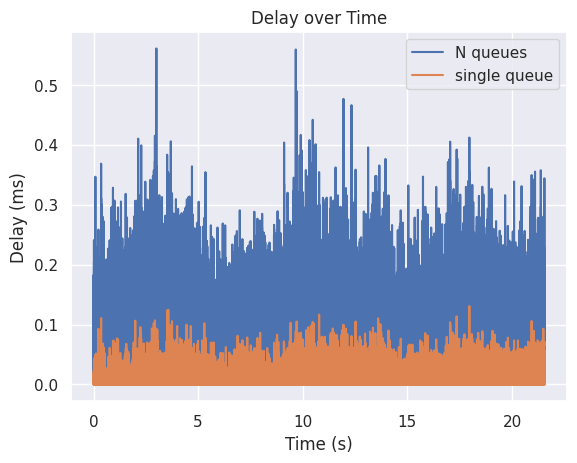

In [ ]:
plt.plot(df_delay_Nq["timestamp_ns"]/1e9, df_delay_Nq["delay_ns"]/1e6, label="N queues")
plt.plot(df_delay_single["timestamp_ns"]/1e9, df_delay_single["delay_ns"]/1e6, label="single queue")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Delay (ms)')
plt.title('Delay over Time')

Text(0.5, 0, 'Delay (s)')

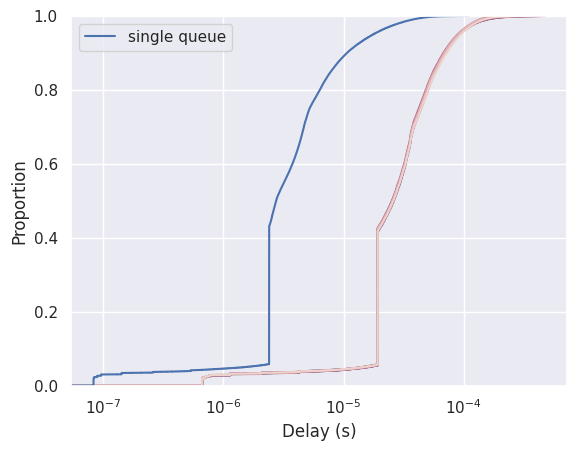

In [ ]:

#sns.ecdfplot( x = df_delay_Nq['delay_ns']/1e9, label=f"N={N} queues" )
sns.ecdfplot( x=df_delay_Nq['delay_ns']/1e9, hue=df_delay_Nq["queue_num"] ) #, label=f"N={N} queues")
sns.ecdfplot( x = df_delay_single['delay_ns']/1e9, label=f"single queue" )

plt.xscale("log")
plt.legend()
plt.xlabel('Delay (s)')

In [ ]:
df_qlen_list = []
df_sum_durations_list = []
for i, q_state_i in enumerate(q_state):
  df_qlen = pd.DataFrame(list(q_state_i), columns=["timestamp_ns", "queue_length_bytes"])
  # Calculate the duration in nanoseconds by subtracting the current timestamp from the next one
  df_qlen["duration_ns"] = df_qlen["timestamp_ns"].shift(-1) - df_qlen["timestamp_ns"]
  df_qlen["queue_num"] = i
  df_qlen_list.append(df_qlen)

  df_sum_durations = df_sum_durations.groupby("queue_length_bytes")["duration_ns"].sum().reset_index()
  df_sum_durations["prob_mass"] = df_sum_durations["duration_ns"]/df_sum_durations["duration_ns"].sum()
  df_sum_durations["ecdf"] = df_sum_durations["prob_mass"].cumsum()
  df_sum_durations["queue_num"] = i
  df_sum_durations_list.append(df_sum_durations)




df_qlen_Nq = pd.concat(df_qlen_list, ignore_index=True)


df_sum_durations_Nq =  pd.concat(df_sum_durations_list, ignore_index=True)
df_sum_durations_Nq["queue_num"] = df_sum_durations_Nq["queue_num"].astype(int)

## Empirical long time scale plots


In [ ]:


#for i, dq in enumerate(delay_meas):
#  df_delay = pd.DataFrame(list(dq), columns=["timestamp_ns", "delay_ns"])
#  df_delay["queue_num"] = i


# Initialize an empty list to collect the rows for the DataFrame
rows = []

# Iterate through the list of deques
for i, dq in enumerate(delay_meas):
    # Convert deque to a list of rows
    #df_delay = pd.DataFrame(list(dq), columns=["timestamp_ns", "delay_ns"])
    df_delay = pd.DataFrame(list(dq), columns=["timestamp_ns", "delay_ns","pkt_id"])
    # Add the queue number column
    df_delay["queue_num"] = i
    # Append the dataframe rows to the list
    rows.append(df_delay)

# Concatenate all the DataFrames into one
df_delay_Nq = pd.concat(rows, ignore_index=True)

# Print the final dataframe
df_delay_Nq

,timestamp_ns,delay_ns,pkt_id,queue_num
0,34004,11360,26.69.40.155:175.240.10.18:443:62403:894589094...,0
1,40546,16434,72.106.214.240:161.73.109.140:80:50197:1504668...,0
2,49934,19046,66.132.245.156:203.127.163.100:443:42677:93408...,0
3,79714,11936,169.107.219.120:170.239.242.122:80:56298:35210...,0
4,82515,9799,212.21.71.170:203.93.231.157:8195:8195:2129174...,0
...,...,...,...,...
30261125,47862937964,18804,186.57.158.12:162.160.152.76:80:47103:40829029...,7
30261126,47862944722,12366,115.76.36.9:173.214.38.140:587:24606:110072484...,7
30261127,47862960204,320,115.76.36.9:173.214.38.140:587:24606:110072484...,7
30261128,47862998009,12000,186.57.158.12:162.160.152.76:80:47103:40829102...,7


In [ ]:
#df_delay_Nq=df_delay_Nq[df_delay_Nq['pkt_id']!=-1]
df_delay_Nq['exit_timestamp_ns'] = df_delay_Nq['timestamp_ns'] + df_delay_Nq['delay_ns']
df_delay_Nq

,timestamp_ns,delay_ns,pkt_id,queue_num,exit_timestamp_ns
0,34004,11360,26.69.40.155:175.240.10.18:443:62403:894589094...,0,45364
1,40546,16434,72.106.214.240:161.73.109.140:80:50197:1504668...,0,56980
2,49934,19046,66.132.245.156:203.127.163.100:443:42677:93408...,0,68980
3,79714,11936,169.107.219.120:170.239.242.122:80:56298:35210...,0,91650
4,82515,9799,212.21.71.170:203.93.231.157:8195:8195:2129174...,0,92314
...,...,...,...,...,...
30261125,47862937964,18804,186.57.158.12:162.160.152.76:80:47103:40829029...,7,47862956768
30261126,47862944722,12366,115.76.36.9:173.214.38.140:587:24606:110072484...,7,47862957088
30261127,47862960204,320,115.76.36.9:173.214.38.140:587:24606:110072484...,7,47862960524
30261128,47862998009,12000,186.57.158.12:162.160.152.76:80:47103:40829102...,7,47863010009


In [ ]:
#df_merged['pkt.id'] = df_merged.index.to_series().str.rsplit(':', n=1).str[0]
df_delay_Nq['flow.id'] = df_delay_Nq['pkt_id'].str.rsplit(':', n=2).str[0]
df_delay_Nq.loc[df_delay_Nq['flow.id'].isna(), 'flow.id'] = -1
df_delay_Nq

,timestamp_ns,delay_ns,pkt_id,queue_num,exit_timestamp_ns,flow.id
0,34004,11360,26.69.40.155:175.240.10.18:443:62403:894589094...,0,45364,26.69.40.155:175.240.10.18:443:62403
1,40546,16434,72.106.214.240:161.73.109.140:80:50197:1504668...,0,56980,72.106.214.240:161.73.109.140:80:50197
2,49934,19046,66.132.245.156:203.127.163.100:443:42677:93408...,0,68980,66.132.245.156:203.127.163.100:443:42677
3,79714,11936,169.107.219.120:170.239.242.122:80:56298:35210...,0,91650,169.107.219.120:170.239.242.122:80:56298
4,82515,9799,212.21.71.170:203.93.231.157:8195:8195:2129174...,0,92314,212.21.71.170:203.93.231.157:8195:8195
...,...,...,...,...,...,...
30261125,47862937964,18804,186.57.158.12:162.160.152.76:80:47103:40829029...,7,47862956768,186.57.158.12:162.160.152.76:80:47103
30261126,47862944722,12366,115.76.36.9:173.214.38.140:587:24606:110072484...,7,47862957088,115.76.36.9:173.214.38.140:587:24606
30261127,47862960204,320,115.76.36.9:173.214.38.140:587:24606:110072484...,7,47862960524,115.76.36.9:173.214.38.140:587:24606
30261128,47862998009,12000,186.57.158.12:162.160.152.76:80:47103:40829102...,7,47863010009,186.57.158.12:162.160.152.76:80:47103


In [ ]:
# 1) sort by x, compute cumulative counts, carry back to df_merged
sx = df_delay_Nq.sort_values('timestamp_ns', kind='mergesort')
sx['index_flow_n_x'] = sx.groupby('flow.id').cumcount()
sx['index_n_x']      = np.arange(len(sx))
#sx['index_n_x']      = sx.groupby(['src', 'ip.dst']).cumcount()

# 2) sort by y, compute cumulative counts, carry back to df_merged
sy = df_delay_Nq.sort_values('exit_timestamp_ns', kind='mergesort')
sy['index_flow_n_y'] = sy.groupby('flow.id').cumcount()
sy['index_n_y']      = np.arange(len(sy))
#sy['index_n_y']      = sy.groupby(['src', 'ip.dst']).cumcount()

# 3) copy results back aligned by index, then leave df_merged sorted by x
df_delay_Nq[['index_flow_n_x', 'index_n_x']] = sx[['index_flow_n_x', 'index_n_x']]
df_delay_Nq[['index_flow_n_y', 'index_n_y']] = sy[['index_flow_n_y', 'index_n_y']]

df_delay_Nq['displacement_flow'] = df_delay_Nq['index_flow_n_y'] - df_delay_Nq['index_flow_n_x']
df_delay_Nq['displacement'] = df_delay_Nq['index_n_y'] - df_delay_Nq['index_n_x']

df_delay_Nq.sort_values('timestamp_ns', kind='mergesort', inplace=True)


In [ ]:
df_delay_Nq

,timestamp_ns,delay_ns,pkt_id,queue_num,exit_timestamp_ns,flow.id,index_flow_n_x,index_n_x,index_flow_n_y,index_n_y,displacement_flow,displacement
18911257,0,1248,-1,5,1248,-1,0,0,0,0,0,0
7566701,2719,11616,46.166.185.64:180.211.115.30:443:58102:1043453...,2,14335,46.166.185.64:180.211.115.30:443:58102,0,1,0,2,0,1
11348001,3949,11616,46.166.185.64:180.211.115.30:443:58102:1043455...,3,15565,46.166.185.64:180.211.115.30:443:58102,1,2,1,4,0,2
7566702,5193,19702,-1,2,24895,-1,1,3,2,6,1,3
15129535,6318,576,-1,4,6894,-1,2,4,1,1,-1,-3
...,...,...,...,...,...,...,...,...,...,...,...,...
26479117,47862999283,11440,-1,6,47863010723,-1,6413354,30261125,6413356,30261127,2,2
7566699,47863000497,320,115.76.36.9:173.214.38.140:587:24606:110072484...,1,47863000817,115.76.36.9:173.214.38.140:587:24606,2432,30261126,2432,30261121,0,-5
30261129,47863001086,9339,-1,7,47863010425,-1,6413355,30261127,6413355,30261126,0,-1
18911256,47863001160,2936,-1,4,47863004096,-1,6413356,30261128,6413354,30261122,-2,-6


In [ ]:
import pickle

# Custom filename for the pickle file
pickle_filename = 'df_delay_Nq_100gig.pickle' # at 60
#pickle_filename = 'df_delay_Nq_100gig_at70g.pickle'
#pickle_filename = 'df_delay_Nq_100gig_at80g.pickle'
#pickle_filename = 'df_delay_Nq_100gig_at80g_singleq.pickle'
#pickle_filename = 'df_delay_Nq_100gig_at60g_singleq.pickle'
#pickle_filename = 'df_delay_Nq_100gig_at35g.pickle' ############### valid

#pickle_filename = 'df_delay_Nq_10gig_at6g_singleq.pickle'
#pickle_filename = 'df_delay_Nq_10gig_at8g_singleq.pickle'
#pickle_filename = 'df_delay_Nq_10gig_at8g.pickle'

#pickle_filename = 'df_delay_Nq_2_4gig_at1_05g.pickle'


# Write the DataFrame to a pickle file
#with open(pickle_filename, 'wb') as f:
#    pickle.dump(df_delay_Nq, f)


# Read the DataFrame from the pickle file
#with open(pickle_filename, 'rb') as f:
#  df_delay_Nq_60 = pickle.load(f)
#  df_delay_Nq_80 = pickle.load(f)
#  df_delay_Nq = pickle.load(f)


# print(f"DataFrame loaded from {pickle_filename}")
# display(loaded_df_delay_Nq.head())

In [ ]:

pickle_filename='/content/drive/MyDrive/Colab Notebooks/rack-analysis/caida datasets/oc-48 public dataset/df_delay_Nq_2_4gig_at1_05g.pickle'
# Read the DataFrame from the pickle file
with open(pickle_filename, 'rb') as f:
  df_delay_Nq_2_4g = pickle.load(f)

pickle_filename='/content/drive/MyDrive/Colab Notebooks/rack-analysis/caida datasets/high speed/2019/df_delay_Nq_10gig_at8g.pickle'
with open(pickle_filename, 'rb') as f:
  df_delay_Nq_10g = pickle.load(f)

pickle_filename='/content/drive/MyDrive/Colab Notebooks/rack-analysis/caida datasets/100g/sampler/df_delay_Nq_100gig_at35g.pickle'
with open(pickle_filename, 'rb') as f:
  df_delay_Nq_100g = pickle.load(f)

In [ ]:
df_delay_Nq_80.loc[df_delay_Nq_80['flow.id']!=-1,'displacement_flow'].value_counts()

,count
displacement_flow,
0,8558870
-1,697795
1,559666
-2,174280
2,153970
...,...
-22,3
-25,2
41,1


In [ ]:
s = pd.to_numeric(df_delay_Nq_100g.loc[df_delay_Nq_100g['flow.id'] != -1, 'displacement_flow'], errors='coerce').dropna()

print(f"=0   : {s.eq(0).mean() * 100:.2f}%")
print(f"<=0   : {s.lt(1).mean() * 100:.2f}%")
print(f">3   : {s.gt(3).mean() * 100:.2f}%")
print(f">30  : {s.gt(30).mean():.3e}")
print(f">300 : {s.gt(300).mean():.3e}")

=0   : 61.55%
<=0   : 81.73%
>3   : 3.87%
>30  : 2.271e-04
>300 : 0.000e+00


In [ ]:
1/3.986e-6

250878.07325639742

In [ ]:

x = df_delay_Nq_100g.loc[df_delay_Nq_100g['flow.id']!=-1, 'displacement_flow'].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_100g = pd.DataFrame({"displacement_flow": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")

##

x = df_delay_Nq_10g.loc[df_delay_Nq_10g['flow.id']!=-1, 'displacement_flow'].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_10g = pd.DataFrame({"displacement_flow": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")

##

x = df_delay_Nq_2_4g.loc[df_delay_Nq_2_4g['flow.id']!=-1, 'displacement_flow'].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_2_4g = pd.DataFrame({"displacement_flow": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")

10536116 points → 187 unique points
23847773 points → 695 unique points
26012105 points → 82 unique points


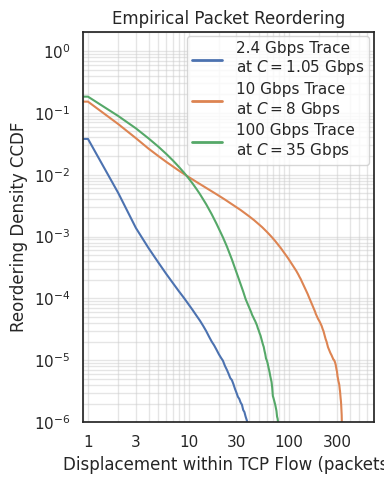

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


fig, ax = plt.subplots(figsize=(4, 5))

c = plt.rcParams['axes.prop_cycle'].by_key()['color']


sns.lineplot(data=ccdf_df_2_4g, x="displacement_flow", y="ccdf", ax=ax, label=None, color=c[0]) #
sns.lineplot(data=ccdf_df_10g, x="displacement_flow", y="ccdf", ax=ax, label=None , color=c[1])
sns.lineplot(data=ccdf_df_100g, x="displacement_flow", y="ccdf", ax=ax, label=None, color=c[2])


ax.set_xscale("log")
ax.set_yscale("log")
xticks = [1, 3, 10, 30, 100, 300]
ax.set_xticks(xticks)
ax.set_xticklabels([str(t) for t in xticks])

plt.xlim(0.9,700)
plt.ylim(1e-6,2)
plt.xlabel('Displacement within TCP Flow (packets)')
plt.ylabel('Reordering Density CCDF')
plt.title('Empirical Packet Reordering') # in Long-Time Scale - $N=8$ queues
plt.grid(True, which="both", alpha=0.5)

#style_handles = [
#    Line2D([0], [0], color="black", lw=2, ls="-"),
#    Line2D([0], [0], color="black", lw=2, ls="--"),
#]
color_handles = [
    Line2D([0], [0], color=c[0], lw=2),
    Line2D([0], [0], color=c[1], lw=2),
    Line2D([0], [0], color=c[2], lw=2),
]

empty = Line2D([], [], linestyle="none")  # spacer

all_handles =  color_handles #[empty] +

labels = [
    "2.4 Gbps Trace \nat $C=1.05$ Gbps",
    "10 Gbps Trace \nat $C=8$ Gbps",
    "100 Gbps Trace \nat $C=35$ Gbps",
]

# --- One combined legend box ---
ax.legend(
    handles=all_handles,
    labels=labels,
    loc="upper right", bbox_to_anchor=(1.01, 1.01), borderpad=0.3,      # space between text and legend frame
    labelspacing=0.3,   # vertical space between legend entries
    #handlelength=2.0,   # length of line symbol
    handletextpad=0.9,
    frameon=True,
)


plt.tight_layout()
#plt.savefig("emp_reordering_loglines_loglog.pdf", bbox_inches="tight", pad_inches=0.5)
plt.show()



In [ ]:
import numpy as np
import pandas as pd

x = df_delay_Nq_60["delay_ns"].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df = pd.DataFrame({"delay_ns": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")


12915178 points → 19724 unique points


In [ ]:
ccdf_df["delay_s"] = ccdf_df["delay_ns"]/1e9
ccdf_df

NameError: name 'ccdf_df' is not defined

In [ ]:
df_delay_Nq

,timestamp_ns,delay_ns,pkt_id,queue_num,exit_timestamp_ns,flow.id,index_flow_n_x,index_n_x,index_flow_n_y,index_n_y,displacement_flow,displacement
6919894,0,91428,3.236.223.25:115.155.229.74:80:1080:2303586169...,2,91428,3.236.223.25:115.155.229.74:80:1080,0,0,0,9,0,9
13840372,15000,83017,3.3.122.124:171.233.191.62:3645:1219:411512600...,4,98017,3.3.122.124:171.233.191.62:3645:1219,0,1,0,10,0,9
0,19000,42910,0.3.117.36:71.143.225.209:80:15366:4096640955:...,0,61910,0.3.117.36:71.143.225.209:80:15366,0,2,0,4,0,2
3461492,28000,14384,3.223.149.166:225.212.134.144:80:51255:2717343...,1,42384,3.223.149.166:225.212.134.144:80:51255,0,3,0,0,0,-3
1,41000,112338,3.3.241.159:4.28.214.10:10560:1448:27307434:0x...,0,153338,3.3.241.159:4.28.214.10:10560:1448,0,4,0,14,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
6919893,240275308000,96554,107.210.17.149:0.2.74.233:2061:8010:1139433201...,1,240275404554,107.210.17.149:0.2.74.233:2061:8010,48,27684008,48,27684001,0,-7
10379662,240275313000,291820,157.193.226.8:4.29.78.70:80:3231:49757779:0x2297,2,240275604820,157.193.226.8:4.29.78.70:80:3231,481,27684009,481,27684011,0,2
17302636,240275323000,91428,241.46.236.233:237.81.251.216:80:44948:2453659...,4,240275414428,241.46.236.233:237.81.251.216:80:44948,5451,27684010,5451,27684002,0,-8
10379663,240275328000,289924,238.109.212.178:238.150.30.12:80:2702:35375299...,2,240275617924,238.109.212.178:238.150.30.12:80:2702,7,27684011,7,27684012,0,1


In [ ]:
import numpy as np
import pandas as pd

x = df_delay_Nq_2_4g["delay_ns"].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_2_4g_d = pd.DataFrame({"delay_ns": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")
ccdf_df_2_4g_d["delay_s"] = ccdf_df_2_4g_d["delay_ns"]/1e9


####

x = df_delay_Nq_10g["delay_ns"].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_10g_d = pd.DataFrame({"delay_ns": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")
ccdf_df_10g_d["delay_s"] = ccdf_df_10g_d["delay_ns"]/1e9

####

x = df_delay_Nq_100g["delay_ns"].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_100g_d = pd.DataFrame({"delay_ns": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")
ccdf_df_100g_d["delay_s"] = ccdf_df_100g_d["delay_ns"]/1e9




27684013 points → 609484 unique points
30261130 points → 578992 unique points
12915178 points → 82078 unique points


In [ ]:
print(f"2.4: {df_delay_Nq_2_4g["delay_ns"].dropna().mean()*1e-3}us")
print(f"10: {df_delay_Nq_10g["delay_ns"].dropna().mean()*1e-3}us")
print(f"100: {df_delay_Nq_100g["delay_ns"].dropna().mean()*1e-3}us")

2.4: 104.16357774221534us
10: 29.97157441513255us
100: 6.2216864231371805us


In [ ]:
import numpy as np
import pandas as pd

x = df_delay_single["delay_ns"].dropna().to_numpy()
x.sort()

# Collapse duplicates
unique_x, counts = np.unique(x, return_counts=True)
n = x.size

# CCDF as P(X >= x)
surv_counts = np.cumsum(counts[::-1])[::-1]
ccdf = surv_counts / n  # same length as unique_x

ccdf_df_single = pd.DataFrame({"delay_ns": unique_x, "ccdf": ccdf})
print(len(x), "points →", len(unique_x), "unique points")
ccdf_df_single["delay_s"] = ccdf_df_single["delay_ns"]/1e9
ccdf_df_single

12915178 points → 9296 unique points


,delay_ns,ccdf,delay_s
0,3,1.000000e+00,3.000000e-09
1,4,9.999595e-01,4.000000e-09
2,5,9.996178e-01,5.000000e-09
3,6,9.741132e-01,6.000000e-09
4,7,9.282955e-01,7.000000e-09
...,...,...,...
9291,14862,3.871414e-07,1.486200e-05
9292,14938,3.097131e-07,1.493800e-05
9293,15016,2.322848e-07,1.501600e-05
9294,15091,1.548566e-07,1.509100e-05


In [ ]:
ti=np.logspace(-8,-1,100)

#2.4
pkt_size_bytes=8*681.38
serv_rate=1.05e9/pkt_size_bytes/8
arr_rate=0.6280603052675459e9/pkt_size_bytes/8
mm1_2_4=  np.exp(-ti*(serv_rate-arr_rate))
mm1bound_2_4= 1 - (1-np.exp(-ti*(serv_rate-arr_rate)) )**8

rho=(arr_rate/serv_rate)
print(rho)
print(f"{1e6/(serv_rate-arr_rate)}us")


#10
pkt_size_bytes=8*894.2
serv_rate=8e9/pkt_size_bytes/8
arr_rate=4.522806504787187e9/pkt_size_bytes/8
mm1_10=  np.exp(-ti*(serv_rate-arr_rate))
mm1bound_10= 1 - (1-np.exp(-ti*(serv_rate-arr_rate)) )**8

rho=(arr_rate/serv_rate)
print(rho)
print(f"{1e6/(serv_rate-arr_rate)}us")

#100
pkt_size_bytes=8*1029.29
serv_rate=35e9/pkt_size_bytes/8
arr_rate=21.2696437458797e9/pkt_size_bytes/8
mm1_100=  np.exp(-ti*(serv_rate-arr_rate))
mm1bound_100= 1 - (1-np.exp(-ti*(serv_rate-arr_rate)) )**8

rho=(arr_rate/serv_rate)
print(rho)
print(f"{1e6/(serv_rate-arr_rate)}us")


#serv_rate=35e9/12000
#arr_rate=20e9/12000
#mm1_single=  (arr_rate/serv_rate)*np.exp(-ti*(serv_rate-arr_rate))

#10G
#serv_rate=8e9/12000/8
#arr_rate=4.5e9/12000/8
#mm1=  (arr_rate/serv_rate)*np.exp(-ti*(serv_rate-arr_rate))

0.598152671683377
103.35202054798708us
0.5653508130983983
16.458330569980966us
0.6077041070251343
4.797731302873655us


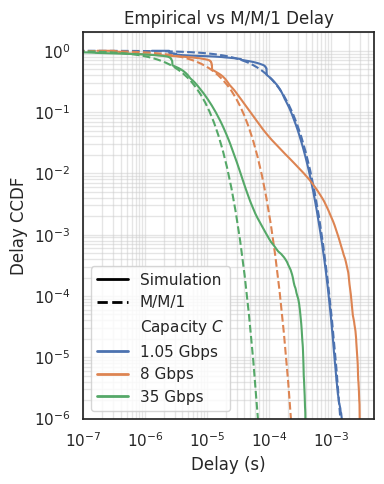

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


fig, ax = plt.subplots(figsize=(4, 5))

c = plt.rcParams['axes.prop_cycle'].by_key()['color']


#sns.lineplot(data=ccdf_df, x="delay_s", y="ccdf", ax=ax, label=r"$\rho=.833$ Simulation")
#sns.lineplot(x=ti,y=mm1, label=r"$\rho=.833$ M/M/1", ls="--") # 60g
#sns.lineplot(data=ccdf_df_single, x="delay_s", y="ccdf", ax=ax, label=r"$\rho=.625$ Simulation - FIFO Queue")
#sns.lineplot(x=ti,y=mm1_single, label=r"$\rho=.625$ M/M/1 - FIFO Queue", ls="--") #80g
sns.lineplot(data=ccdf_df_2_4g_d, x="delay_s", y="ccdf", ax=ax, label=None, color=c[0]) #
sns.lineplot(x=ti,y=mm1_2_4, label=None, ls="--", color=c[0])
sns.lineplot(data=ccdf_df_10g_d, x="delay_s", y="ccdf", ax=ax, label=None , color=c[1])
sns.lineplot(x=ti,y=mm1_10, label=None, ls="--", color=c[1])
sns.lineplot(data=ccdf_df_100g_d, x="delay_s", y="ccdf", ax=ax, label=None, color=c[2])
sns.lineplot(x=ti,y=mm1_100, label=None, ls="--", color=c[2])

#sns.lineplot(x=ti,y=mm1bound_10, label=rf"$\rho={rho:.2f}$ M/M/1 upper bound - $N=8$ queues", ls="--") # 80g


ax.set_xscale("log")
ax.set_yscale("log")

plt.xlim(1e-7,5e-3)
plt.ylim(1e-6,2)
plt.xlabel('Delay (s)')
plt.ylabel('Delay CCDF')
plt.title('Empirical vs M/M/1 Delay') # in Long-Time Scale - $N=8$ queues
plt.grid(True, which="both",alpha=0.5)
#plt.grid(True)


style_handles = [
    Line2D([0], [0], color="black", lw=2, ls="-"),
    Line2D([0], [0], color="black", lw=2, ls="--"),
]
color_handles = [
    Line2D([0], [0], color=c[0], lw=2),
    Line2D([0], [0], color=c[1], lw=2),
    Line2D([0], [0], color=c[2], lw=2),
]

empty = Line2D([], [], linestyle="none")  # spacer

all_handles =  style_handles + [empty] + color_handles #[empty] +

labels = [
    #"Model",
    "Simulation",
    "M/M/1",
    "Capacity $C$",
    "1.05 Gbps",
    "8 Gbps",
    "35 Gbps",
]

# --- One combined legend box ---
ax.legend(
    handles=all_handles,
    labels=labels,
    loc="best",
    frameon=True,
)


plt.tight_layout()
#plt.savefig("emp_delay_vs_mm1.pdf")
#plt.savefig("emp_delay_vs_mm1_loglines.pdf")
plt.show()

